# Install packages

In [ ]:
from google.colab import drive # import drive from google colab
drive.mount("/content/drive") 
!pip install neo
!pip install matplotlib_scalebar
!pip install ffmpeg
!pip install Ipython --upgrade
!pip3 install setuptools==65.5.0
%cd /content/drive/MyDrive/ff_repo/Multifirefly-Project

# Import packages

In [ ]:
# # For local use of the notebook
# %cd /Users/dusiyi/Library/CloudStorage/GoogleDrive-sd80@rice.edu/My Drive/ff_repo/Multifirefly-Project

In [ ]:

%load_ext autoreload
%autoreload 2

from pathlib import Path
import os
if Path.cwd().parts[-1] != 'notebooks':
    os.chdir('..')
    from add_path import find_path
    current_path = find_path()
    os.chdir(current_path)

import sys
 

from data_wrangling import basic_func, process_raw_data, monkey_data_classes
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization import plot_behaviors_utils
from non_behavioral_analysis import neural_analysis, neural_data_processing, visualize_neural_data
from non_behavioral_analysis.prep_other_data_for_neural_analysis import prep_ff_data, prep_final_behavioral_data, prep_monkey_data, prep_target_df
from non_behavioral_analysis.planning_neural import planning_neural_class

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from matplotlib import rc
from os.path import exists
from numpy import random
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from importlib import reload
import neo
import gc

import sys
import os
import numpy as np
import torch
from numpy import pi
from matplotlib import pyplot as plt

import numpy as np
import scipy.linalg as linalg
import scipy.interpolate as interpolate
from scipy.signal import fftconvolve


from scipy.io import loadmat
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import sys

import scipy.sparse as sparse
import matplotlib.pylab as plt

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

# Data path

In [3]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/individual_monkey_data/monkey_Bruno/data_0330"

# Retrieve data

## Retrieve monkey data

In [ ]:

data_item = monkey_data_classes.ProcessMonkeyData(raw_data_folder_path=raw_data_folder_path)
data_item.save_important_files(exists_ok=True)
data_item.make_PlotTrials_args()

monkey_information = data_item.monkey_information.copy()
ff_dataframe = data_item.ff_dataframe.copy()
ff_life_sorted = data_item.ff_life_sorted
ff_real_position_sorted = data_item.ff_real_position_sorted
ff_believed_position_sorted = data_item.ff_believed_position_sorted
cluster_around_target_indices = data_item.cluster_around_target_indices
ff_caught_T_new = data_item.ff_caught_T_new
ff_flash_sorted = data_item.ff_flash_sorted

all_trial_patterns = data_item.all_trial_patterns
pattern_frequencies = data_item.pattern_frequencies
feature_statistics = data_item.feature_statistics

## Neural data (in bins)

In [71]:
spike_df, spike_times_in_s, spike_clusters = neural_data_processing.make_spike_df(raw_data_folder_path=raw_data_folder_path,
                                                                                  sampling_rate=20000)
bin_width=0.25
time_bins, neural_stacked_bins = neural_data_processing.bin_spikes(spike_df, bin_width=bin_width)
# neural_bins_df = pd.DataFrame(neural_stacked_bins, columns=np.arange(neural_stacked_bins.shape[1]))
# neural_bins_df['bin'] = np.arange(neural_bins_df.shape[0])

num_bins = neural_stacked_bins.shape[0]
unique_clusters = np.sort(spike_df.cluster.unique())

In [ ]:
time_bins

In [ ]:
315603/7.890075

In [ ]:
unique_clusters

# Monkey and ff data

## Get convolution pattern

In [ ]:
window_width, num_bins_in_window, convolve_pattern = neural_data_processing.calculate_window_parameters(window_width=1, bin_width=0.25)
print("True window width: ", window_width)


## Plotting kwargs

In [ ]:
trial_total_num = 10
PLAYER = "monkey"

classic_plot_kwargs = {'player': PLAYER,
                       'show_stops': True,
                       'show_believed_target_positions': True,
                       'show_reward_boundary': True,
                       'show_scale_bar': True,
                       'show_eye_positions': True,
                       'show_eye_positions_on_the_right': True,
                       'show_connect_path_eye_positions': True,
                       #=== below is different from animation_plot_kwargs
                       'hitting_arena_edge_ok': False,
                       'trial_too_short_ok': False}


combined_plot_kwargs = {'player': PLAYER,
                        'combined_plot': True,
                        'show_alive_fireflies': False,
                        'show_title': False,
                        'show_start': False}


plot_chunks_kwargs = {'player': PLAYER,
                      'show_stops': True,
                      'show_believed_target_positions': True,
                      'show_reward_boundary': True,
                      'show_scale_bar': True,
                      'hitting_arena_edge_ok': True,
                      'trial_too_short_ok': True,
                      'show_connect_path_ff': True,
                      'trail_color_var': 'abs_ddw',
                      'show_colorbar': True}


plot_polar_kwargs = {'rmax': 400,
                    'show_visible_ff': True,
                    'hitting_arena_edge_ok': True,
                    'return_axes': True,
                    'colors_show_overall_time': True,
                    'show_ff_in_memory': True,
                    'show_target_at_being_caught': True
}

print("player is", PLAYER)

animation_plot_kwargs = classic_plot_kwargs
animation_plot_kwargs['as_part_of_animation'] = True
animation_plot_kwargs['show_eye_positions_on_the_right'] = False   
animation_plot_kwargs['hitting_arena_edge_ok'] = True
animation_plot_kwargs['trial_too_short_ok'] = True
animation_plot_kwargs['images_dir'] = None

## Monkey data processing

In [11]:
rebinned_monkey_info_essential, data_item.monkey_information = prep_monkey_data.make_rebinned_monkey_info_essential(data_item.monkey_information, time_bins, data_item.ff_caught_T_new, convolve_pattern, window_width)

## ff data processing

In [ ]:
data_item.monkey_information

In [13]:
ff_dataframe_unique_ff, ff_dataframe_unique_visible_ff, min_ff_info, min_visible_ff_info = prep_ff_data.prepare_ff_data(data_item, time_bins)

In [ ]:
min_ff_info.columns

## target_df

In [15]:
target_df, target_average_info, target_min_info, target_max_info = prep_target_df.retrieve_or_make_and_target_df_into_h5(data_item,
        exists_ok=True)

In [ ]:
target_df.columns

## category_info

In [17]:
pattern_df, pattern_df_condensed = prep_monkey_data.prepare_pattern_df(data_item, time_bins)

In [ ]:
pattern_df.columns

## binned_features

In [19]:
feature_dataframes_to_merge = (ff_dataframe_unique_visible_ff, min_ff_info, min_visible_ff_info, target_average_info, target_min_info, target_max_info, pattern_df_condensed)
binned_features = prep_final_behavioral_data.make_binned_features(ff_dataframe_unique_ff, num_bins, ff_caught_T_new, time_bins, feature_dataframes_to_merge)

## Final_behavioral_data

In [70]:
final_behavioral_data = prep_final_behavioral_data.make_final_behavioral_data(rebinned_monkey_info_essential, binned_features)


In [ ]:
final_behavioral_data.columns

# Neural data

## prepare x_var

In [72]:
max_bin = final_behavioral_data['bin'].max()
x_var, spikes_in_bins_df = neural_data_processing.prepare_x_var_and_spikes_in_bins_df(max_bin, neural_stacked_bins)

## Convolve

In [23]:
x_var_convolved = neural_data_processing.convolve_neural_data(x_var, kernel_len=7)

## Lag

In [ ]:
lag_numbers = range(-3, 4)
x_var_lags = neural_data_processing.add_lags_to_each_feature(spikes_in_bins_df, lag_numbers)
y_var_lags = neural_data_processing.add_lags_to_each_feature(final_behavioral_data, lag_numbers)
y_var_lags

In [ ]:
synthetic_data = np.concatenate([np.arange(20).reshape(-1,1), np.arange(1, 21).reshape(-1,1)], axis=1)
synthetic_data_lags = neural_data_processing.add_lags_to_each_feature(synthetic_data, lag_numbers)
synthetic_data_lags

## firing rate

In [ ]:
# get convolved windows
all_windows = np.repeat(bin_width, len(x_var_convolved))
convolved_windows = np.convolve(all_windows, convolve_pattern, 'same')

# apply convolution to every column in spikes_in_bins_df
firing_rate_df = spikes_in_bins_df.apply(lambda x: np.convolve(x, convolve_pattern, 'same')/convolved_windows, axis=0)
firing_rate_df

## Plot interspike intervals

In [ ]:
num_spikes = 1000
plt.plot(range(num_spikes), np.diff(spike_times_in_s[:num_spikes+1]))
plt.title("Interspike intervals")
plt.show()


In [ ]:
num_spikes = 100
plt.figure(figsize=(10, 7))
plt.scatter(spike_times_in_s[:num_spikes], np.ones(num_spikes), s=5)
plt.title("Spikes")
plt.show()


### Differentiate them based on clusters

In [ ]:
spikes_to_plot = range(10000, 10500)
plt.figure(figsize=(10, 10))
plt.scatter(spike_df.time[spikes_to_plot], spike_df.cluster[spikes_to_plot], s=2)
# fix the yticks to be the cluster names
plt.yticks(spike_df.cluster[spikes_to_plot].unique(), spike_df.cluster[spikes_to_plot].unique())
plt.title("Spikes")
plt.show()


### Correlation between spike clusters

In [ ]:
corr_coeff = pd.DataFrame(neural_stacked_bins).corr()
plt.figure(figsize = (15, 15))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

# Relating neural data to other variables

### Catching a target

In [ ]:
time_to_sample_from = range(len(ff_caught_T_new))
visualize_neural_data.make_individual_spike_plots(time_to_sample_from, spike_df, unique_clusters, max_plots=2)

In [ ]:
time_to_sample_from = range(len(ff_caught_T_new))
visualize_neural_data.make_overlaid_spike_plot(time_to_sample_from, spike_df, unique_clusters, max_rows_to_plot=4)

### Stop (whether or not resulting in a capture?)

In [ ]:
time_to_sample_from = monkey_information[monkey_information['monkey_speeddummy'] == 0].monkey_t.values
visualize_neural_data.make_overlaid_spike_plot(time_to_sample_from, spike_df, unique_clusters, max_rows_to_plot=4)

### High speed

In [ ]:
time_to_sample_from = monkey_information[monkey_information['monkey_speed'] > 100].monkey_t.values
visualize_neural_data.make_overlaid_spike_plot(time_to_sample_from, spike_df, unique_clusters, max_rows_to_plot=4)

### Visible_before_last_one instances

In [ ]:
filepath = os.path.join(data_item.data_folder_name, 'target_cluster_df.csv')
current_i = 1
max_plots = 3

if exists(filepath):
    target_cluster_df = pd.read_csv(filepath).drop(["Unnamed: 0"], axis=1)
    target_cluster_VBLO = pattern_by_trials.find_target_cluster_visible_before_last_one(target_cluster_df, ff_caught_T_new)
    visualize_neural_data.make_individual_spike_plot_from_target_cluster_VBLO(target_cluster_VBLO, spike_df, unique_clusters, starting_row=current_i, max_plots=max_plots)
    current_i += max_plots
else:
    print("No target_cluster_df.csv file found")


### Just try it randomly

In [ ]:
time_to_sample_from = random.uniform(100, 1000, 100)
visualize_neural_data.make_overlaid_spike_plot(time_to_sample_from, spike_df, unique_clusters, max_rows_to_plot=5)

# Linear regression

Regressing the behavioral variables individually (as y_var) against all neural activity

In [ ]:
final_behavioral_data

In [ ]:
# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = range(final_behavioral_data.bin.max())
for i, column in enumerate(final_behavioral_data.columns):
    visualize_neural_data.plot_regression(final_behavioral_data, column, x_var, min_R_squared_to_plot=0.2)

    # if i == 3:
    #     break

In [ ]:
# plot one neural cluster against one behavioral variable

cluster_num, behavioral_column = 6, 'monkey_speed'
bins_to_plot = range(1000, 1200)
x_values, y_values = x_var[bins_to_plot, cluster_num], final_behavioral_data[behavioral_column][bins_to_plot]
reg = LinearRegression().fit(x_values.reshape(-1, 1), y_values)

plt.scatter(x_values, y_values, color='blue', s=1)
plt.plot(x_values, reg.predict(x_values.reshape(-1, 1)), color='red', linewidth=1)
plt.show()

# Multicollinearity

## VIF

In [ ]:
gc.collect()

In [41]:
# vif = pd.DataFrame({
#     "VIF Factor": [variance_inflation_factor(y_var_lags, i) for i in range(y_var_lags.shape[1])],
#     "features": y_var_lags.columns
# }).sort_values(by='VIF Factor', ascending=False).round(1)

# vif

In [ ]:
# vif = pd.DataFrame({
#     "VIF Factor": [variance_inflation_factor(x_var_lags, i) for i in range(x_var_lags.shape[1])],
#     "features": x_var_lags.columns
# }).sort_values(by='VIF Factor', ascending=False).round(1)

# vif

In [43]:
vif = pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(final_behavioral_data.values, i) for i in range(final_behavioral_data.shape[1])],
    "features": final_behavioral_data.columns
}).sort_values(by='VIF Factor', ascending=False).round(1)

vif

,VIF Factor,features
28,3550.30000,avg_target_angle
29,3295.10000,avg_target_angle_to_boundary
32,3032.10000,avg_target_last_seen_angle
33,2788.80000,avg_target_last_seen_angle_to_boundary
12,1083.10000,monkey_speeddummy
22,1068.90000,min_abs_ff_angle
15,1057.10000,num_stops
23,1042.40000,min_abs_ff_angle_boundary
26,235.80000,min_abs_visible_ff_angle_boundary
25,235.40000,min_abs_visible_ff_angle


## Correlations between features

In [44]:
specific_columns = vif[vif["VIF Factor"] > 5].features.values
specific_columns

array(['avg_target_angle', 'avg_target_angle_to_boundary',
       'avg_target_last_seen_angle',
       'avg_target_last_seen_angle_to_boundary', 'monkey_speeddummy',
       'min_abs_ff_angle', 'num_stops', 'min_abs_ff_angle_boundary',
       'min_abs_visible_ff_angle_boundary', 'min_abs_visible_ff_angle',
       'avg_target_cluster_last_seen_angle_to_boundary',
       'avg_target_cluster_last_seen_angle',
       'avg_target_cluster_last_seen_angle_frozen',
       'avg_target_last_seen_angle_frozen', 'RDy', 'RDz', 'stop_rate',
       'avg_target_cluster_last_seen_angle_to_boundary_frozen', 'LDy',
       'avg_target_cluster_last_seen_distance',
       'avg_target_last_seen_angle_to_boundary_frozen', 'LDz',
       'avg_target_last_seen_distance',
       'avg_target_last_seen_distance_frozen',
       'avg_target_cluster_last_seen_distance_frozen',
       'avg_target_distance', 'catching_ff', 'num_caught_ff',
       'monkey_speed', 'num_alive_ff', 'max_target_cluster_visible_dummy',
       

In [45]:
# specific_columns = ['traj_curv_when_alt_ff_first_seen',
#        'stop_ff_distance_when_alt_ff_first_seen',
#        'stop_arc_curv_when_alt_ff_first_seen',
#        'stop_arc_dheading_when_alt_ff_first_seen',
#        'stop_opt_arc_curv_when_alt_ff_first_seen',
#        'stop_ff_angle_when_alt_ff_first_seen',
#        'alt_ff_angle_when_stop_ff_first_seen',
#        'alt_ff_distance_when_stop_ff_first_seen',
#        'traj_curv_when_alt_ff_last_seen',
#        'stop_opt_arc_curv_when_stop_ff_last_seen',
#        'stop_opt_arc_curv_when_stop_ff_first_seen',
#        'traj_curv_when_stop_ff_last_seen',
#        'angle_from_m_before_stop_to_alt_ff', 'stop_point_index', 'bin',
#        'point_index', 'time_rel_to_stop', 'alt_ff_distance',
#        'stop_ff_distance', 'alt_arc_curv', 'alt_opt_arc_curv',
#        'stop_opt_arc_curv', 'traj_curv']

In [46]:
specific_columns = np.append(specific_columns, 'stop_success_rate')

In [47]:
# drop these items from specific_columns: 'avg_target_angle', 'avg_target_angle_to_boundary', 'avg_target_last_seen_angle', 'avg_target_last_seen_angle_to_boundary', 'num_stops', 'min_abs_ff_angle_boundary', 'min_abs_visible_ff_angle_boundary', 'avg_target_cluster_last_seen_angle_to_boundary', 'RDy', 'RDz', 'avg_target_cluster_last_seen_angle_to_boundary_frozen', 'avg_target_last_seen_angle_to_boundary_frozen', 'avg_target_last_seen_distance', 'avg_target_last_seen_distance_frozen', 'avg_target_distance', 'num_caught_ff', 'max_target_visible_dummy', 'avg_target_last_seen_time', 'bin'
specific_columns = specific_columns[~np.isin(specific_columns, ['avg_target_angle', 'avg_target_angle_to_boundary', 'avg_target_last_seen_angle', 'avg_target_last_seen_angle_to_boundary', 'num_stops', 'min_abs_ff_angle_boundary', 'min_abs_visible_ff_angle_boundary', 'avg_target_cluster_last_seen_angle_to_boundary', 'RDy', 'RDz', 'avg_target_cluster_last_seen_angle_to_boundary_frozen', 'avg_target_last_seen_angle_to_boundary_frozen', 'avg_target_last_seen_distance', 'avg_target_last_seen_distance_frozen', 'avg_target_distance', 'num_caught_ff', 'max_target_visible_dummy', 'avg_target_last_seen_time', 'bin'])]

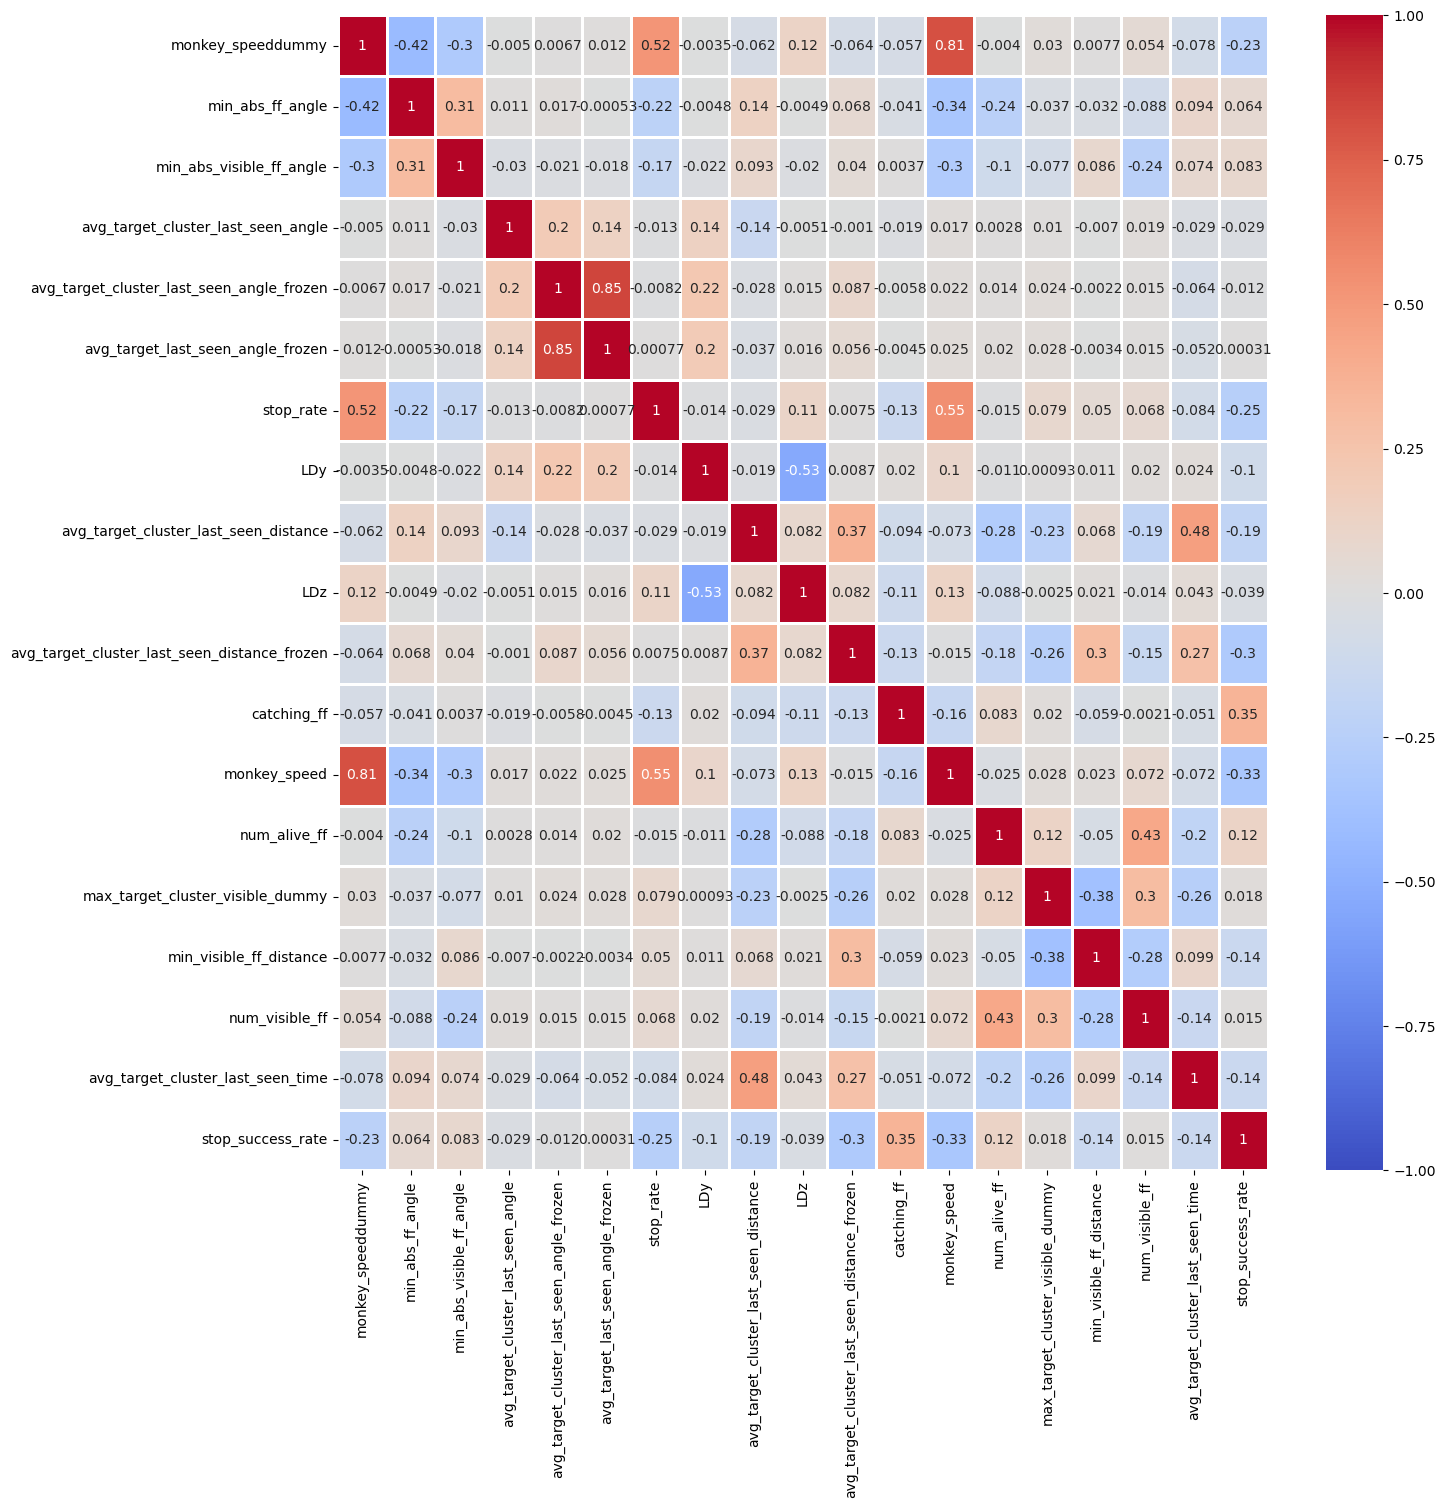

In [48]:
# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif[vif["VIF Factor"] > 5].features.values
corr_coeff = final_behavioral_data[specific_columns].corr()
plt.figure(figsize = (15, 15))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

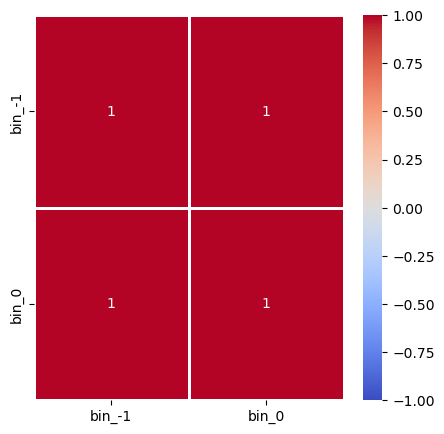

In [49]:
# See the correlation between the lags of the variable "bin"
y_var_lags = neural_data_processing.add_lags_to_each_feature(final_behavioral_data, lag_numbers= range(-1, 1))
corr_coeff = y_var_lags[['bin_-1', 'bin_0']].corr()
plt.figure(figsize = (5, 5))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## Categorize variables

In [50]:
temporal_vars = ['monkey_speeddummy',
                'try_a_few_times_indice_dummy',
                'give_up_after_trying_indice_dummy',
                'ignore_sudden_flas_indice_dummy',
                'two_in_a_row',
                'visible_before_last_one',
                'disappear_latest',
                'ignore_sudden_flash',
                'try_a_few_times',
                'give_up_after_trying',
                'cluster_around_target',
                'waste_cluster_around_target',
                'catching_ff',
                'min_target_has_disappeared_for_last_time_dummy',
                'min_target_cluster_has_disappeared_for_last_time_dummy',
                'max_target_visible_dummy', 
                'max_target_cluster_visible_dummy']

spatial_vars = [x for x in final_behavioral_data.columns if x not in temporal_vars]
spatial_vars

['bin',
 'LDy',
 'LDz',
 'RDy',
 'RDz',
 'gaze_monkey_view_x',
 'gaze_monkey_view_y',
 'gaze_world_x',
 'gaze_world_y',
 'monkey_speed',
 'monkey_angles',
 'monkey_dw',
 'monkey_ddw',
 'monkey_ddv',
 'num_stops',
 'num_caught_ff',
 'stop_rate',
 'stop_success_rate',
 'num_alive_ff',
 'num_visible_ff',
 'min_ff_distance',
 'min_abs_ff_angle',
 'min_abs_ff_angle_boundary',
 'min_visible_ff_distance',
 'min_abs_visible_ff_angle',
 'min_abs_visible_ff_angle_boundary',
 'avg_target_distance',
 'avg_target_angle',
 'avg_target_angle_to_boundary',
 'avg_target_last_seen_time',
 'avg_target_last_seen_distance',
 'avg_target_last_seen_angle',
 'avg_target_last_seen_angle_to_boundary',
 'avg_target_last_seen_distance_frozen',
 'avg_target_last_seen_angle_frozen',
 'avg_target_last_seen_angle_to_boundary_frozen',
 'avg_target_cluster_last_seen_time',
 'avg_target_cluster_last_seen_distance',
 'avg_target_cluster_last_seen_angle',
 'avg_target_cluster_last_seen_angle_to_boundary',
 'avg_target_clu

## Dropping some columns

In [51]:
# drop all columns with _boundary at the end - that eliminated 7
final_behavioral_data = final_behavioral_data.drop(columns = [col for col in final_behavioral_data.columns if '_boundary' in col])
temporal_vars = [col for col in temporal_vars if '_boundary' not in col]
spatial_vars = [col for col in spatial_vars if '_boundary' not in col]

In [52]:
columns_to_drop = ['RDy', 'RDz', 'num_caught_ff', 'num_stops', 'avg_target_last_seen_time', 'avg_target_last_seen_distance', 
                   'avg_target_last_seen_angle', 'avg_target_distance', 'avg_target_angle', 'avg_target_last_seen_distance_frozen', 'max_target_visible_dummy']

temporal_vars = list(set(temporal_vars) - set(columns_to_drop))
spatial_vars = list(set(spatial_vars) - set(columns_to_drop))
final_behavioral_data.drop(columns=[col for col in columns_to_drop if col in final_behavioral_data.columns], inplace=True)

## Use reduced_var_list from PGAM

In [53]:
# # Use reduced_var_list from PGAM
# temporal_vars = [col for col in temporal_vars if col in reduced_var_list]
# spatial_vars = [col for col in spatial_vars if col in reduced_var_list]
# final_behavioral_data = final_behavioral_data.loc[:, reduced_var_list]

## see autocorrelation for each variable

In [54]:
final_behavioral_data.columns

Index(['bin', 'LDy', 'LDz', 'gaze_monkey_view_x', 'gaze_monkey_view_y',
       'gaze_world_x', 'gaze_world_y', 'monkey_speed', 'monkey_angles',
       'monkey_dw', 'monkey_speeddummy', 'monkey_ddw', 'monkey_ddv',
       'stop_rate', 'stop_success_rate', 'num_alive_ff', 'num_visible_ff',
       'min_ff_distance', 'min_abs_ff_angle', 'min_visible_ff_distance',
       'min_abs_visible_ff_angle', 'avg_target_last_seen_angle_frozen',
       'avg_target_cluster_last_seen_time',
       'avg_target_cluster_last_seen_distance',
       'avg_target_cluster_last_seen_angle',
       'avg_target_cluster_last_seen_distance_frozen',
       'avg_target_cluster_last_seen_angle_frozen',
       'min_target_has_disappeared_for_last_time_dummy',
       'min_target_cluster_has_disappeared_for_last_time_dummy',
       'max_target_cluster_visible_dummy', 'try_a_few_times_indice_dummy',
       'give_up_after_trying_indice_dummy', 'ignore_sudden_flas_indice_dummy',
       'two_in_a_row', 'visible_before_last_one

In [55]:
# see autocorrelation for each variable
for column in final_behavioral_data.columns:
    print(column)
    for lag in range(1, 8):
        print('lag' , lag, ', autocorr:', final_behavioral_data[column].autocorr(lag))
    print('\n')



bin
lag 1 , autocorr: 1.0
lag 2 , autocorr: 1.0
lag 3 , autocorr: 1.0
lag 4 , autocorr: 0.9999999999999998
lag 5 , autocorr: 1.0
lag 6 , autocorr: 1.0
lag 7 , autocorr: 0.9999999999999998


LDy
lag 1 , autocorr: 0.5214220173695971
lag 2 , autocorr: 0.27519415605284225
lag 3 , autocorr: 0.15413238110375366
lag 4 , autocorr: 0.08768008783378739
lag 5 , autocorr: 0.05777417880591406
lag 6 , autocorr: 0.028173699310294478
lag 7 , autocorr: 0.01762066240864916


LDz
lag 1 , autocorr: 0.18761478374573068
lag 2 , autocorr: 0.08534519751912398
lag 3 , autocorr: 0.05972106810981571
lag 4 , autocorr: 0.013606282440196642
lag 5 , autocorr: -0.0018137901519733257
lag 6 , autocorr: -0.024947473212928114
lag 7 , autocorr: -0.016151990175544213


gaze_monkey_view_x
lag 1 , autocorr: 0.4406599237932124
lag 2 , autocorr: 0.23088214016252204
lag 3 , autocorr: 0.14644178759455767
lag 4 , autocorr: 0.08698137885403752
lag 5 , autocorr: 0.07029702421163225
lag 6 , autocorr: 0.03433449969963484
lag 7 , auto

# USE PLANNING INFO ALONE

Neural data (changed bin_width here)

## get data

In [56]:
spike_df, spike_times_in_s, spike_clusters = neural_data_processing.make_spike_df(raw_data_folder_path="all_monkey_data/raw_monkey_data/individual_monkey_data/monkey_Bruno/data_0330")
bin_width=0.1
time_bins, neural_stacked_bins = neural_data_processing.bin_spikes(spike_df, bin_width=bin_width)
neural_bins_df = pd.DataFrame(neural_stacked_bins, columns=np.arange(neural_stacked_bins.shape[1]))
neural_bins_df['bin'] = np.arange(neural_bins_df.shape[0])

num_bins = neural_stacked_bins.shape[0]
unique_clusters = np.sort(spike_df.cluster.unique())

In [57]:
ref_point_mode='distance'
ref_point_value=-150

normalize = False
eliminate_outliers = False
use_curvature_to_ff_center = False
curv_of_traj_mode = 'time'
window_for_curv_of_traj=[-1, 1]

pn = planning_neural_class.PlanningAndNeural(raw_data_folder_path=raw_data_folder_path)
pn.streamline_organizing_info(ref_point_mode='time after stop ff visible', ref_point_value=0.1, 
                               curv_of_traj_mode=curv_of_traj_mode, window_for_curv_of_traj=window_for_curv_of_traj, truncate_curv_of_traj_by_time_of_capture=True,
                               use_curvature_to_ff_center=use_curvature_to_ff_center,  eliminate_outliers=eliminate_outliers)


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/non_behavioral_analysis/eye_positions.py:119: RuntimeWarning: divide by zero encountered in divide
  numerator_component = 1/np.tan(ver_theta)**2 - np.tan(inside_tan)**2


Retrieved monkey data from  all_monkey_data/raw_monkey_data/individual_monkey_data/monkey_Bruno/data_0330/processed_data/basic_info/monkey_information.csv  and ff data from  all_monkey_data/raw_monkey_data/individual_monkey_data/monkey_Bruno/data_0330/processed_data/basic_info/ff_basic_info.npz


/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/non_behavioral_analysis/eye_positions.py:119: RuntimeWarning: divide by zero encountered in divide
  numerator_component = 1/np.tan(ver_theta)**2 - np.tan(inside_tan)**2


shared_stops_near_ff_df has 528 rows
Retrieving shared_stops_near_ff_df succeeded
Number of new ff xy within 1 cm of monkey: 1 out of 299. Setting them to monkey position.
Note: 1 fireflies are too close to the monkey/agent. Their angles are set to 0.
Retrieving Bruno_stop_0_1 from all_monkey_data/raw_monkey_data/individual_monkey_data/monkey_Bruno/data_0330/processed_data/updated_planning_info/heading_info/test/Bruno_stop_0_1 succeeded


In [58]:
columns_to_drop = ['alt_opt_arc_dheading',
 'alt_arc_curv',
  'angle_from_stop_ff_landing_to_alt_ff',
  
 # preserve "alt + alt" or 'stop + stop' but not 'alt + stop' or 'stop + alt'. Otherwise the correlation shall be too great
#  'alt_ff_distance_when_stop_ff_first_seen',
#  'alt_ff_distance_when_stop_ff_last_seen',
#  'stop_ff_distance_when_alt_ff_first_seen',
#  'stop_ff_distance_when_alt_ff_last_seen',
#  'stop_ff_angle_when_alt_ff_first_seen',
#  'alt_ff_angle_when_stop_ff_first_seen',
#  'stop_ff_angle_when_alt_ff_last_seen',
#  'alt_ff_angle_when_stop_ff_last_seen',
]


In [81]:
gc.collect()

0

In [92]:
df = pn.both_ff_across_time_df
df

,alt_ff_angle,alt_ff_distance,alt_arc_curv,alt_opt_arc_curv,alt_opt_arc_dheading,time_rel_to_stop,traj_curv,stop_ff_angle,stop_ff_distance,stop_arc_curv,stop_opt_arc_curv,stop_opt_arc_dheading,stop_point_index,bin
point_index,,,,,,,,,,,,,,
1833,-0.54674,398.54102,-0.00261,-0.00250,-1.04335,-1.82635,-0.00120,-0.48219,239.04897,-0.00388,-0.00357,-0.88072,1945,122
1848,-0.26897,359.67684,-0.00148,-0.00163,-0.58415,-1.57759,-0.00644,-0.22692,199.34043,-0.00226,-0.00275,-0.53951,1945,123
1864,-0.03726,308.13876,-0.00024,-0.00045,-0.13877,-1.31197,-0.00315,-0.00303,147.57340,-0.00004,-0.00096,-0.14025,1945,124
1879,0.01101,267.40960,0.00008,0.00036,0.09646,-1.06297,0.00117,0.06069,106.89807,0.00113,0.00117,0.11313,1945,125
1894,-0.00557,267.22771,-0.00004,-0.00000,-0.00026,-0.81405,0.00117,0.04452,106.71935,0.00083,0.00117,0.11299,1945,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19425,0.02174,110.11885,0.00039,0.00100,0.10074,1.57990,0.00100,NaN,NaN,NaN,NaN,NaN,19328,1278
19440,0.03977,60.23512,0.00132,0.00067,0.03392,1.82890,0.00067,NaN,NaN,NaN,NaN,NaN,19328,1279
19455,0.03747,24.60177,0.00234,0.00234,0.03417,2.07790,0.00234,NaN,NaN,NaN,NaN,NaN,19328,1280


In [94]:
all_planning_info = pn.get_all_planning_info(time_bins, both_ff_across_time_df_exists_ok=False)

# drop rows with NA in all_planning_info and print the percentage of rows dropped
all_planning_info2 = all_planning_info.drop(columns=columns_to_drop).copy()
all_planning_info2 = all_planning_info2.dropna().copy()
all_planning_info2.drop(columns={'stop_point_index', 'point_index'}, inplace=True)
print("Percentage of rows dropped: ", 1 - all_planning_info2.shape[0] / len(all_planning_info))
final_behavioral_data = all_planning_info2.copy()

neural_bins_sub2 = neural_bins_df[neural_bins_df['bin'].isin(all_planning_info2['bin'].values)]
x_var = neural_bins_sub2.drop(columns=['bin']).values

Having processed 0 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 10 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 20 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 30 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 40 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 50 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 60 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 70 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 80 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 90 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 100 rows out of 299 of the stops_near_ff_df for both_ff_across_time_df.
Having processed 110 rows out of

In [95]:
max_bin = final_behavioral_data['bin'].max()
x_var, spikes_in_bins_df = neural_data_processing.prepare_x_var_and_spikes_in_bins_df(max_bin, x_var)

In [100]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.DataFrame(all_planning_info.isnull().sum())

,0
point_index,0
alt_ff_angle,156
alt_ff_distance,156
alt_arc_curv,156
alt_opt_arc_curv,156
alt_opt_arc_dheading,156
time_rel_to_stop,156
traj_curv,156
stop_ff_angle,1713
stop_ff_distance,1713


In [96]:
print('x_var.shape:', x_var.shape)
print('spikes_in_bins_df.shape:', spikes_in_bins_df.shape)
print('final_behavioral_data.shape:', final_behavioral_data.shape)

x_var.shape: (2156, 16)
spikes_in_bins_df.shape: (2156, 17)
final_behavioral_data.shape: (2156, 13)


In [64]:
# neural_bins_sub = neural_bins_df[neural_bins_df['bin'].isin(all_planning_info['bin'].values)]

In [65]:
# x_var = neural_bins_sub.drop(columns=['bin']).values

In [98]:
# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = range(all_planning_info.bin.max())
for i, column in enumerate(final_behavioral_data.columns):
    visualize_neural_data.plot_regression(final_behavioral_data, column, x_var, bins_to_plot=None, min_R_squared_to_plot=0.3)
    # if i == 3:
    #     break

R: 0.08, R^2: 0.006 -- alt_ff_angle
R: 0.1, R^2: 0.011 -- alt_ff_distance
R: 0.07, R^2: 0.005 -- alt_opt_arc_curv
R: 0.1, R^2: 0.01 -- time_rel_to_stop
R: 0.09, R^2: 0.009 -- traj_curv
R: 0.08, R^2: 0.007 -- stop_ff_angle
R: 0.1, R^2: 0.011 -- stop_ff_distance
R: 0.08, R^2: 0.007 -- stop_arc_curv
R: 0.09, R^2: 0.009 -- stop_opt_arc_curv
R: 0.09, R^2: 0.008 -- stop_opt_arc_dheading
R: 0.37, R^2: 0.135 -- bin
R: 0.1, R^2: 0.009 -- angle_from_m_before_stop_to_stop_ff
R: 0.05, R^2: 0.003 -- angle_from_m_before_stop_to_alt_ff


### VIF

In [ ]:
vif = pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(final_behavioral_data.values, i) for i in range(final_behavioral_data.shape[1])],
    "features": final_behavioral_data.columns
}).sort_values(by='VIF Factor', ascending=False).round(1)
vif.reset_index(drop=False, inplace=True)

vif

In [ ]:
specific_columns = vif.iloc[:15].features.values
specific_columns

In [ ]:
fff = [feature for feature in vif.features.tolist() if ('alt' in feature) and ('stop' in feature)]
fff

In [ ]:
fff = [feature for feature in vif.features.tolist() if ('alt_arc_' in feature) or ('alt_opt' in feature)]
fff

In [ ]:
 specific_columns = ['stop_ff_distance',
 'stop_ff_angle',
 'stop_opt_arc_dheading',
 'stop_arc_curv']

 specific_columns = ['stop_ff_angle',
 'stop_ff_distance',
 'stop_opt_arc_dheading',
 'stop_opt_arc_curv',
 'stop_arc_curv']

In [ ]:
 specific_columns = ['alt_ff_angle',
 'alt_ff_distance',
 'alt_opt_arc_dheading',
 'alt_opt_arc_curv',
 'alt_arc_curv']

In [ ]:
fff = [feature for feature in vif.features.tolist() if ('alt' in feature) & ('first_seen' not in feature) & ('last_seen' in feature)]
fff

### Correlations between features

In [ ]:
# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif[vif["VIF Factor"] > 5].features.values
corr_coeff = final_behavioral_data[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (12, 12))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

## Categorize variables

In [ ]:
final_behavioral_data.columns

In [ ]:
temporal_vars = ['time_rel_to_stop',
 'time_when_alt_ff_first_seen_rel_to_stop',
 'time_when_stop_ff_first_seen_rel_to_stop',
 'time_when_alt_ff_last_seen_rel_to_stop',
 'time_when_stop_ff_last_seen_rel_to_stop',
 ]

spatial_vars = [x for x in final_behavioral_data.columns if x not in temporal_vars]
spatial_vars

# Experiment

In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import RidgeCV

# Assuming X and Y are your two datasets
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])  # Set your alpha values for tuning
ridge.fit(x_var_lags, y_var_lags)

# Now you can use the fitted ridge model with CCA
cca = CCA(n_components=2)
cca.fit(ridge.predict(x_var_lags), y_var_lags)

In [ ]:

# Transform the datasets to get the canonical covariates
X_c, Y_c = cca.transform(ridge.predict(x_var_lags), y_var_lags)

# Print the canonical covariates
print("Canonical covariates for X (X_c):")
print(X_c)
print("Canonical covariates for Y (Y_c):")
print(Y_c)

In [ ]:
# Transform the datasets to get the canonical covariates
X_c, Y_c = cca.transform(ridge.predict(x_var_lags), y_var_lags)

# Calculate the canonical correlation coefficients
canonical_correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]

# Print the canonical correlation coefficients
print("Canonical correlation coefficients:")
print(canonical_correlations)

In [ ]:
cca.score(ridge.predict(x_var_lags), y_var_lags)

In [103]:
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
import numpy as np

import cProfile
import pstats

def main():
    # Assuming x_var_lags and y_var_lags are your two datasets
    # lasso = MultiTaskLassoCV(alphas=[0.1, 1.0, 10.0])  # Set your alpha values for tuning
    lasso = MultiTaskLassoCV(alphas=[1.0], n_jobs=-1)  # Set your alpha values for tuning
    lasso.fit(x_var_lags, y_var_lags)

    # Use the fitted lasso model with CCA
    cca = CCA(n_components=10)
    cca.fit(lasso.predict(x_var_lags), y_var_lags)

    # Transform the datasets to get the canonical covariates
    X_c, Y_c = cca.transform(lasso.predict(x_var_lags), y_var_lags)

    # Calculate the canonical correlation coefficients
    canonical_correlations = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])]

    # Print the canonical correlation coefficients
    print("Canonical correlation coefficients:")
    print(canonical_correlations)
    return canonical_correlations


# Profile the main function
cProfile.run('main()', 'profile_output')

# Print profiling results
p = pstats.Stats('profile_output')
p.sort_stats('cumulative').print_stats(10)

/opt/anaconda3/envs/ff_venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10575040795.063955, tolerance: 51601885.34356141
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/envs/ff_venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10774113295.724577, tolerance: 45675213.43475038
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/envs/ff_venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10557425972.419086, tolerance: 45649737.527170904
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/envs/ff_venv/lib/p

Canonical correlation coefficients:
[1.0, 0.8936378372582943, 0.993807315511504, 0.837302409899281, 0.7710510107064716, 0.6816635247913017, 0.5601638179427474, 0.4726332783178297, 0.42859715307621127, 0.40003076456039477]
Sat Sep 21 14:36:01 2024    profile_output

         1362152 function calls (1361537 primitive calls) in 4456.274 seconds

   Ordered by: cumulative time
   List reduced from 817 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      5/1    0.002    0.000 4456.274 4456.274 {built-in method builtins.exec}
        1    0.001    0.001 4456.273 4456.273 <string>:1(<module>)
        1    0.041    0.041 4456.273 4456.273 /var/folders/d_/db37ytbs7n7dtdqnpjf4lffh0000gn/T/ipykernel_38144/2016135571.py:8(main)
      3/2    0.011    0.004 4456.023 2228.011 /opt/anaconda3/envs/ff_venv/lib/python3.9/site-packages/sklearn/base.py:1457(wrapper)
        1    0.000    0.000 4442.277 4442.277 /opt/anaconda3/envs/ff_venv/lib/python3.

In [102]:
y_var_lags.shape

(14397, 120)

In [ ]:
final_behavioral_data.columns

In [382]:
column = 'stop_success_rate'
y_var = final_behavioral_data[column]
x_var = y_var_lags

# # drop rows where either x_var or y_var is nan, and print the number of dropped rows
# n_rows = len(x_var)
# dropped_rows = x_var[np.isnan(x_var) | np.isnan(y_var)]
# x_var = x_var[~np.isnan(x_var) & ~np.isnan(y_var)]
# y_var = y_var[~np.isnan(x_var) & ~np.isnan(y_var)]
# print(f"Dropped {len(dropped_rows)} rows out of {n_rows} rows for {column} due to nan values.")


reg = LinearRegression().fit(x_var, y_var)

In [ ]:
reg.coef_

In [ ]:
for column in ['stop_success_rate',
                # 'avg_target_cluster_last_seen_distance_frozen',
                # 'avg_target_cluster_last_seen_distance'
                ]:
    visualize_neural_data.plot_regression(final_behavioral_data, column, y_var_lags, min_R_squared_to_plot=0.3)

In [ ]:
final_behavioral_data['stop_success_rate']

In [ ]:
y_var_lags.shape

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## No lagging

In [ ]:
# Define data and scaler
scaler = StandardScaler()
X1, X2 = spikes_in_bins_df.drop(columns=['bin'], errors='ignore'), final_behavioral_data.drop(columns=['bin'], errors='ignore')

# Scale data
X1_sc, X2_sc = scaler.fit_transform(X1), scaler.fit_transform(X2)

# Define and fit CCA
n_comp = 10
cca = CCA(scale=False, n_components=n_comp).fit(X1_sc, X2_sc)

# Transform datasets to obtain canonical variates
X1_c, X2_c = cca.transform(X1_sc, X2_sc)

# Calculate canonical correlations
canon_corr = [np.corrcoef(X1_c[:, i], X2_c[:, i])[1][0] for i in range(n_comp)]

# Plot canonical correlations
bar_names = [f'CC {i+1}' for i in range(n_comp)]
plt.bar(bar_names, canon_corr, color='lightgrey', width=0.8, edgecolor='k')

# Label y value on each bar
for i, val in enumerate(canon_corr):
    plt.text(i, val, f'{val:.2f}', ha='center', va='bottom')

plt.show()

lagging_included = False

## Loop over lags

In [ ]:
gc.collect()

In [122]:
# rename columns in final_behavioral_data
column_names = {
    'catching_ff': 'whether catching ff at current time bin',
    'min_target_cluster_has_disappeared_for_last_time_dummy': 'whether target cluster has disappeared for last time',           
    'max_target_cluster_visible_dummy': 'whether target cluster is visible',
    'bin': 'bin',
    'gaze_world_y': 'gaze y-coordinate',
    'monkey_speed': 'monkey linear speed',
    'monkey_dw': 'monkey linear acceleration',
    'monkey_ddw': 'change in monkey linear acceleration',
    'monkey_ddv': 'change in monkey angular acceleration',
    'avg_target_cluster_last_seen_distance': 'distance of target cluster last seen',
    'avg_target_cluster_last_seen_angle': 'angle of target cluster last seen'
}

final_behavioral_data_renamed = final_behavioral_data.rename(columns=column_names)

final_behavioral_data_renamed.drop(columns=['bin'], inplace=True, errors='ignore')

In [103]:
final_behavioral_data_renamed.drop(columns=['stop_success_rate',
                                            'avg_target_cluster_last_seen_distance_frozen',
                                            'distance of target cluster last seen',
                                            'whether catching ff at current time bin'], inplace=True, errors='ignore')

In [ ]:
'distance_of_target_cluster_last_seen'

In [ ]:
# iterate across different lags
for n_lags in range(3, 4):
    
    #print("n_lags", n_lags, "include_negative_lags:", include_negative_lags)

    #lag_numbers = range(-n_lags,0+1)
    lag_numbers = range(-n_lags, n_lags+1)
    #lag_numbers = range(0, n_lags+1)
    print("lag_numbers:", lag_numbers)

    x_var_lags = neural_data_processing.add_lags_to_each_feature(spikes_in_bins_df.drop(columns=['bin'], errors='ignore'), lag_numbers = lag_numbers)
    y_var_lags = neural_data_processing.add_lags_to_each_feature(final_behavioral_data_renamed, lag_numbers= range(-3, 4))

    #X1 = pd.DataFrame(neural_stacked_bins_sub) 
    #X1 = pd.DataFrame(modelX.copy())

    X1 = x_var_lags
    X2 = y_var_lags

    scaler = StandardScaler()
    X1_sc = scaler.fit_transform(X1) #scale data
    X2_sc = scaler.fit_transform(X2) 
    n_comp=12 #choose number of canonical variates pairs 
    cca = CCA(scale=False, n_components=n_comp) #define CCA
    cca.fit(X1_sc, X2_sc) #fit our scaled data
    X1_c, X2_c = cca.transform(X1_sc, X2_sc) #transform our datasests to obtain canonical variates

    canon_corr = [np.corrcoef(X1_c[:, i], X2_c[:, i])[1][0] for i in range(n_comp)]
    print(np.around(np.array(canon_corr), 2))
    # bar_names = ['CC {}'.format(i+1) for i in range(n_comp)]
    # plt.bar(bar_names, canon_corr, color='lightgrey', width = 0.8, edgecolor='k')
    # plt.show() 
    # 

coef_df = pd.DataFrame(np.round(cca.coef_, 2), columns = [X1.columns])
coef_df.index = X2.columns

lagging_included = True
    

## loadings squared

In [125]:
x_loadings = neural_analysis.calculate_cca_loadings(X1_sc, X1_c)
y_loadings = neural_analysis.calculate_cca_loadings(X2_sc, X2_c)

### neurons

In [ ]:
x_loadings = neural_analysis.calculate_cca_loadings(X1_sc, X1_c)
y_loadings = neural_analysis.calculate_cca_loadings(X2_sc, X2_c)

loading_squared = pd.DataFrame(np.round(x_loadings**2, 3))
loading_squared['feature'] = X1.columns 
if lagging_included:
    loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))
else:
    loading_squared['feature_category'] = loading_squared['feature']
num_variates = cca.x_loadings_.shape[1]


num_variates = x_loadings.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 5)


### behavior

In [ ]:
x_loadings = neural_analysis.calculate_cca_loadings(X1_sc, X1_c)
y_loadings = neural_analysis.calculate_cca_loadings(X2_sc, X2_c)

loading_squared = pd.DataFrame(np.round(y_loadings**2, 3))
loading_squared['feature'] = X2.columns 
if lagging_included:
    loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))
else:
    loading_squared['feature_category'] = loading_squared['feature']

num_variates = cca.x_loadings_.shape[1]


num_variates = y_loadings.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 8)


## cca's "loadings" squared ranked

### neurons

In [ ]:
loading_squared

In [ ]:
loading_squared = pd.DataFrame(np.round(cca.x_loadings_**2, 3))
loading_squared['feature'] = X1.columns 
loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))

num_variates = cca.x_loadings_.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 10)


### behavior

In [ ]:
cca.y_loadings_[cca.y_loadings_>1]

In [ ]:
loading_squared = pd.DataFrame(np.round(cca.y_loadings_**2, 3))
loading_squared['feature'] = X2.columns
loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))
# fill empty strings in feature_category with the same value as feature
loading_squared.loc[loading_squared['feature_category']=='', 'feature_category'] = loading_squared.loc[loading_squared['feature_category']=='', 'feature']

num_variates = cca.y_loadings_.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 7)


## abs weights ranked

### neurons

In [ ]:
loading_squared = pd.DataFrame(np.round(np.abs(cca.x_weights_), 3))
loading_squared['feature'] = X1.columns 
loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))

num_variates = cca.x_weights_.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 10)


### behavior

In [ ]:
cca.y_loadings_[cca.y_loadings_>1]

In [ ]:
loading_squared = pd.DataFrame(np.round(np.abs(cca.y_weights_), 3))
loading_squared['feature'] = X2.columns
loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))
# fill empty strings in feature_category with the same value as feature
loading_squared.loc[loading_squared['feature_category']=='', 'feature_category'] = loading_squared.loc[loading_squared['feature_category']=='', 'feature']

num_variates = cca.y_weights_.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 10)


## plot real weights

### neurons

In [ ]:
reload(neural_analysis)

In [ ]:
loading_squared = pd.DataFrame(np.round(cca.x_weights_, 3))
loading_squared['feature'] = X1.columns 
loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))

num_variates = cca.x_weights_.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 10)


### behavior

In [ ]:
cca.y_loadings_[cca.y_loadings_>1]

In [ ]:
loading_squared = pd.DataFrame(np.round(cca.y_weights_, 3))
loading_squared['feature'] = X2.columns
loading_squared['feature_category'] = loading_squared['feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))
# fill empty strings in feature_category with the same value as feature
loading_squared.loc[loading_squared['feature_category']=='', 'feature_category'] = loading_squared.loc[loading_squared['feature_category']=='', 'feature']

num_variates = cca.y_weights_.shape[1]
neural_analysis.make_a_series_of_barplots_of_ranked_loadings(loading_squared, canon_corr, num_variates, keep_one_value_for_each_feature = True, max_features_to_show_per_plot = 10)


In [ ]:
stop here

## Distribution of each feature

In [ ]:
X2_sc_df = pd.DataFrame(X2_sc, columns = X2.columns)
X2_sc_df.describe()

In [ ]:
#for column in X2_sc_df.columns[:60]:
for column in X2_sc_df.columns[:6]:
    sns.boxplot(X2_sc_df[column])
    plt.show()
    

## heatmap
raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(coef_df.iloc[:10, :10], cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

In [ ]:
cca.x_weights_

# Pyrcca

## data scaling and splitting

In [143]:
import rcca

In [144]:
X1 = spikes_in_bins_df
X2 = final_behavioral_data

In [145]:
# X1, X2 = pd.DataFrame(x_var2), all_planning_info2



In [146]:
scaler = StandardScaler()
X1_sc = scaler.fit_transform(X1) #scale data
X2_sc = scaler.fit_transform(X2) 

In [ ]:
final_behavioral_data.shape

## train and validate

In [ ]:
# use all data

nComponents = 10 # min(p,q) components
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents,)
cca2.train([X1_sc, X2_sc])
print('Canonical Correlation Per Component Pair:',cca2.cancorrs)
print('% Shared Variance:',cca2.cancorrs**2)

In [ ]:
train1, test1, train2, test2 = train_test_split(X1_sc, X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 4
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])
testcorrs = cca2.validate([test1, test2])
testcorrs

## compute_ev

In [ ]:
cca2.compute_ev([test1, test2])

## canonical components

In [ ]:
# canonical components
cca2.comps

## canonical weights

In [ ]:
cca2.ws[0]

## predicted values

In [ ]:
cca2.preds[0].shape

In [ ]:
cca2.preds[1].shape

In [ ]:
cca2.corrs[1].shape

## canonical components

In [ ]:
# CVX 
cca2.comps[0]
# First CV for X 
cca2.comps[0][:,0]
# Second CV for X
cca2.comps[0][:,1]
# CVY
cca2.comps[1]
# First CV for Y
cca2.comps[1][:,0]
# Second CV for Y 
cca2.comps[1][:,1]

## plot canonical correlations

In [ ]:
# https://github.com/gallantlab/pyrcca/blob/main/examples/Pyrcca_usage_example.ipynb

# Imports
import matplotlib.pyplot as plt
# from brewer2mpl import qualitative
from palettable.colorbrewer import qualitative
%matplotlib inline


# Plot canonical correlations (cca2.cancorrs)
plt.plot(np.arange(nComponents)+1, cca2.cancorrs, 'ko')
plt.xlim(0.5, 0.5+nComponents)
plt.xticks(np.arange(nComponents)+1)
plt.xlabel('Canonical component')
plt.ylabel('Canonical correlation')
plt.title('Canonical correlations')
print('''The canonical correlations are:\n
Component 1: %.02f\n
Component 2: %.02f\n
Component 3: %.02f\n
Component 4: %.02f\n
''' % tuple(cca2.cancorrs[:4]))

In [158]:
# # to check if any column causes invalid eigenvalues
# import rcca
# nComponents = 2 # min(p,q) components
# cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents,)
# # train on data
# for num_columns in range(2, 64):
#     print('num_columns', num_columns)
#     cca2.train([X1.iloc[:,:num_columns], X2.iloc[:,:num_columns]])
#     print('Canonical Correlation Per Component Pair:',cca2.cancorrs)
#     print('% Shared Variance:',cca2.cancorrs**2)

In [ ]:
stop here

# mvlearn.embed.cca

In [353]:
import mvlearn # so that the import doesn't conflict with others
#from mvlearn.embed import CCA, MCCA, KMCCA
from mvlearn.plotting import crossviews_plot

In [ ]:
# the default is no regularization meaning this is SUMCORR-AVGVAR MCCA
cca = mvlearn.embed.CCA(n_components=7)
cca_scores = cca.fit_transform([X1_sc, X2_sc])

# # the fit-transform method outputs the scores for each view
# crossviews_plot(cca_scores,
#                 title='CCA scores (first two views fitted)',
#                 equal_axes=True,
#                 scatter_kwargs={'alpha': 0.4, 's': 2.0})

# In the 2 view setting, a variety of interpretable statistics can be
# calculated. We assess the canonical correlations achieved and
# their significance using the p-values from a Wilk's Lambda test

stats = cca.stats(cca_scores)
print(f'Canonical Correlations: {stats["r"]}')
print(f'Wilk\'s Lambda Test pvalues: {stats["pF"]}')

# sparsecca

In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import svd
from statsmodels.multivariate.cancorr import CanCorr

from sparsecca import cca_ipls
from sparsecca import cca_pmd
from sparsecca import multicca_pmd
from sparsecca import pmd

In [ ]:
def print_weights(name, weights):
    first = weights[:, 0] / np.max(np.abs(weights[:, 0]))
    print(name + ': ' + ', '.join(['{:.3f}'.format(item) for item in first]))


In [ ]:
X1_sc.shape

Canonical Correlations: [0.71324562 0.6767706  0.47372339 0.31371873 0.21360348 0.18737692
 0.17000209 0.14722853 0.13814004 0.10762202 0.09883986 0.08222663
 0.06290811 0.05768485 0.05385522 0.04545233]
Wilk's Lambda Test pvalues: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00001263 0.10131203
 0.78706826 0.90795917 0.94518834 0.96179924]

In [ ]:
stats_cca = CanCorr(X1_sc, X2_sc)

print(stats_cca.corr_test().summary())
print_weights('X', stats_cca.x_cancoef)
print_weights('Z', stats_cca.y_cancoef)

# PGAM

I might need to run this on google colab ...? Or, look into clusters

In [ ]:
if not '/Users/dusiyi/Documents/Multifirefly-Project/PGAM/src/PGAM' in sys.path: 
    sys.path.append('/Users/dusiyi/Documents/Multifirefly-Project/PGAM/src/PGAM')
from GAM_library import *
import gam_data_handlers as gdh
from post_processing import postprocess_results
from scipy.io import savemat

## temporal kernel

modified from PGAM_Tutorial.ipynb

In [ ]:
temporal_columns = final_behavioral_data[temporal_vars]
spatial_columns = final_behavioral_data[spatial_vars]

scaler = StandardScaler()
spatial_columns_scaled = scaler.fit_transform(spatial_columns) 
spatial_columns = pd.DataFrame(spatial_columns_scaled, columns = spatial_columns.columns)

#temporal_columns_scaled = scaler.fit_transform(temporal_columns) #scale data
#temporal_columns = pd.DataFrame(temporal_columns_scaled, columns = temporal_columns.columns)

In [ ]:
num_trials = 10
column_length = len(final_behavioral_data.iloc[:,1])
num_repeats = math.ceil(column_length/num_trials)
trial_ids = np.repeat(np.arange(num_trials), num_repeats)
trial_ids = trial_ids[:column_length]

In [ ]:
# set some trial ids
## trial_ids = np.zeros(len(final_behavioral_data.iloc[:,1]))

# define the b-spline params
kernel_h_legnth = int(10/bin_width) # duration of the kernel h(t) in time points 
if kernel_h_legnth%2 == 0:
    kernel_h_legnth += 1 


#num_int_knots = 12 # number of internal knots used to represent h
num_int_knots = 8
order = 4


# define the "smooths_handler" container
sm_handler = gdh.smooths_handler()



for column in temporal_columns.columns:
    # add the covariate & evaluate the convolution
    sm_handler.add_smooth(column, 
                            [temporal_columns[column].values], 
                            is_temporal_kernel=True, 
                            ord=order, 
                            knots_num=num_int_knots,
                            trial_idx=trial_ids,
                            kernel_length=kernel_h_legnth,
                            kernel_direction=0,
                            time_bin=bin_width)


   
   
   
    # # sm_handler['varname'] process and stores the B-spline for the variable
    # # below we retrive the B-spline convolved with the "event" variable
    # convolved_ev = sm_handler[column].X.toarray()

    # # retrive the B-spline used for the convolution
    # basis = sm_handler[column].basis_kernel.toarray()

    # # plot the basis & the convolved events
    # plt.figure(figsize=(8,3))
    # plt.suptitle('%s Filter'%dict_kernel[kernel_direction])

    # # basis for the kenel h
    # plt.subplot(121)
    # plt.title('kernel basis')
    # tps = np.repeat(np.arange(kernel_h_legnth)-kernel_h_legnth//2, basis.shape[1]).reshape(basis.shape)
    # plt.plot(tps, basis)
    # plt.xlabel('time points')

    # plt.subplot(122)
    # plt.title('convolved events')

    # # select a time point interval containing an event
    # idx0, idx1 = np.where(event == 1)[0][2] - 100, np.where(event == 1)[0][2] + 400

    # # extract the events convolved with each of the B-spline elements
    # conv = convolved_ev[idx0:idx1,:]

    # tps = np.arange(0,idx1-idx0) - 100
    # tps = np.repeat(tps,conv.shape[1]).reshape(conv.shape)
    # plt.plot(tps, conv)
    # plt.vlines(tps[0,0] + np.where(event[idx0:idx1])[0],0,1.5,'k',ls='--',label='event')
    # plt.xlabel('time points')
    # plt.legend()


## spatial variable

In [ ]:
# add the 1d spatial variable

order = 4

for column in spatial_columns.columns:
    column_values = spatial_columns[column].values
    # add the variable
    if column in sm_handler.smooths_var:
        sm_handler.smooths_var.remove(column)
        sm_handler.smooths_dict.pop(column)
        
    #int_knots = np.linspace(min(column_values),max(column_values),10)
    int_knots = np.linspace(min(column_values),max(column_values),6)
    knots = np.hstack(([int_knots[0]]*(order-1), int_knots, [int_knots[-1]]*(order-1)))
    print(knots)
    sm_handler.add_smooth(column, [column_values], 
                        knots=[knots], 
                        ord=order, 
                        is_temporal_kernel=False,
                        trial_idx=trial_ids, 
                        is_cyclic=[False])


    # # retrive the b-spline evaluated at x.
    # X_1D = sm_handler[column].X.toarray()


    # # sort for plotting
    # plt.figure()
    # plt.title(column)
    # idx_srt = np.argsort(column_values)
    # X_srt = X_1D[idx_srt]
    # p = plt.plot(X_srt)

    # # plt.figure()
    # # plt.title('Unordered')
    # # p = plt.plot(X_1D)

    # # plt.figure()
    # # plt.title('Scatter plot')
    # # plt.scatter(range(len(column_values)), column_values)

    # #plt.plot(range(len(column_values[idx_srt])), column_values[idx_srt])


    # # the size of basis set grows as n^m where n is the basis in the 1D case, and m is the number of dimensions
    # print('Size of X_1D', X_1D.shape)


## Run

In [ ]:
link = sm.genmod.families.links.log()
poissFam = sm.genmod.families.family.Poisson(link=link)

spk_counts = spikes_in_bins_df.iloc[:len(column_values), 1].values

# create the pgam model
pgam = general_additive_model(sm_handler,
                              sm_handler.smooths_var, # list of covariate we want to include in the model
                              spk_counts, # vector of spike counts
                              poissFam # poisson family with exponential link from statsmodels.api
                             )

# with with all covariate, remove according to stat testing, and then refit
full, reduced = pgam.fit_full_and_reduced(sm_handler.smooths_var, 
                                          th_pval=0.001,# pval for significance of covariate icluseioon
                                          max_iter=10 ** 2, # max number of iteration
                                          use_dgcv=True, # learn the smoothing penalties by dgcv
                                          trial_num_vec=trial_ids)
        
print('Minimal subset of variables driving the activity:')
print(reduced.var_list)

In [ ]:
print(full.var_list)

In [ ]:
reduced.var_list

## Post-processing

In [ ]:
train_trials = trial_ids % 3 != 1
train_trials

In [ ]:
# string with the neuron identifier
neuron_id = 'neuron_000_session_1_monkey_001'
# dictionary containing some information about the neuron, keys must be strings and values can be anything
# since are stored with type object.
info_save = {'x':100,
             'y':801.2,
             'brain_region': 'V1',
             'subject':'monkey_001'
            }


# assume that we used 90% of the trials for training, 10% for evaluation
res = postprocess_results(neuron_id, spk_counts, full, reduced, train_trials, sm_handler, poissFam, trial_ids, 
                          var_zscore_par=None, info_save=info_save, bins=kernel_h_legnth)
                           


In [ ]:
# find which variables in res['variable'] are in reduced.var_list
# and then plot the corresponding x_rate_Hz
indices_of_vars_to_plot = np.where(np.isin(res['variable'], reduced.var_list))[0]
reduced_var_list = reduced.var_list

In [ ]:
res['variable']

In [ ]:
var_labels = res['variable']

In [ ]:
# rename each variable to the corresponding label
var_labels[var_labels=='catching_ff'] = 'whether catching ff at current time bin'
var_labels[var_labels=='min_target_cluster_has_disappeared_for_last_time_dummy'] = 'whether target cluster has disappeared for last time'
var_labels[var_labels=='max_target_cluster_visible_dummy'] = 'whether target cluster is visible'
var_labels[var_labels=='bin'] = 'bin'
var_labels[var_labels=='gaze_world_y'] = 'gaze y-coordinate'
var_labels[var_labels=='monkey_speed'] = 'monkey linear speed'
var_labels[var_labels=='monkey_dw'] = 'monkey linear acceleration'
var_labels[var_labels=='monkey_ddw'] = 'change in monkey linear acceleration'
var_labels[var_labels=='monkey_ddv'] = 'change in monkey angular acceleration'
var_labels[var_labels=='avg_target_cluster_last_seen_distance'] = 'distance of target cluster last seen'
var_labels[var_labels=='avg_target_cluster_last_seen_angle'] = 'angle of target cluster last seen'

res['variable'] = var_labels
    

In [ ]:
neural_analysis.plot_pgam_tuning_functions(res, indices_of_vars_to_plot=indices_of_vars_to_plot)

In [ ]:
stop!

# try original code

In [ ]:
## inputs parameters  
num_events = 6000
time_points = 3 * 10 ** 5  # 30 mins at 0.006 ms resolution
rate = 5. * 0.006  # Hz rate of the final kernel
variance = 5.  # spatial input and nuisance variance
int_knots_num = 20  # num of internal knots for the spline basis
order = 4  # spline order

## assume 200 trials
trial_ids = np.repeat(np.arange(200),time_points//200)

## create temporal input
idx = np.random.choice(np.arange(time_points), num_events, replace=False)
events = np.zeros(time_points)
events[idx] = 1

rv = sts.multivariate_normal(mean=[0, 0], cov= variance * np.eye(2))
samp = rv.rvs(time_points)
spatial_var = samp[:, 0]
nuisance_var = samp[:, 1]

# truncate X to avoid jumps in the resp function
sele_idx = np.abs(spatial_var) < 5
spatial_var = spatial_var[sele_idx]
nuisance_var = nuisance_var[sele_idx]
while spatial_var.shape[0] < time_points:
    tmpX = rv.rvs(10 ** 4)
    sele_idx = np.abs(tmpX[:, 0]) < 5
    tmpX = tmpX[sele_idx, :]

    spatial_var = np.hstack((spatial_var, tmpX[:, 0]))
    nuisance_var = np.hstack((nuisance_var, tmpX[:, 1]))
spatial_var = spatial_var[:time_points]
nuisance_var = nuisance_var[:time_points]

# create a resp function
knots = np.hstack(([-5]*3, np.linspace(-5,5,8),[5]*3))
beta = np.arange(10)
beta = beta / np.linalg.norm(beta)
beta = np.hstack((beta[5:], beta[:5][::-1]))
resp_func = lambda x : np.dot(gdh.splineDesign(knots, x, order, der=0),beta)

filter_used_conv = sts.gamma.pdf(np.linspace(0,20,100),a=2) - sts.gamma.pdf(np.linspace(0,20,100),a=5)
filter_used_conv = np.hstack((np.zeros(101),filter_used_conv))*2
# mean of the spike counts depending on spatial_var and events
log_mu0 = resp_func(spatial_var)
for tr in np.unique(trial_ids):
    log_mu0[trial_ids == tr] = log_mu0[trial_ids == tr] + np.convolve(events[trial_ids == tr], filter_used_conv, mode='same')

# adjust mean rate
const = np.log(np.mean(np.exp(log_mu0)) / rate)
log_mu0 = log_mu0 - const

# generate spikes
spk_counts = np.random.poisson(np.exp(log_mu0))

In [ ]:
# plot the firing rate and the spike counts generated
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.arange(1000) * 0.006, np.exp(log_mu0)[:1000]/0.006)
plt.title('firing rate [Hz]', fontsize=16)
plt.xlabel('time[sec]', fontsize=12)

plt.subplot(122)
plt.plot(np.arange(1000) * 0.006, spk_counts[:1000])
plt.title('6ms binned spike counts', fontsize=16)
plt.xlabel('time[sec]', fontsize=12)

### 2.2.2 Create the *smooths_handler* object and fit the model
Below we create the smooths_handler object and run a fit. We include a "nuisance" spatial variable, that is not driving the neuron, the fit will learn to discard the variable;

In [ ]:
import statsmodels.api as sm

# Creating the class
sm_handler = smooths_handler()
# Creating the knots (notice the over-representation of edge knots)
knots = np.hstack(([-5]*3, np.linspace(-5,5,15),[5]*3))
# Using smooths_handler class to add variables 
sm_handler.add_smooth('spatial', [spatial_var], knots=[knots], ord=4, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)

sm_handler.add_smooth('nuisance', [nuisance_var], knots=[knots], ord=4, is_temporal_kernel=False,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2)

sm_handler.add_smooth('temporal', [events], knots=None, ord=4, is_temporal_kernel=True,
                     trial_idx=trial_ids, is_cyclic=[False],penalty_type='der', der=2,
                     knots_num=10, kernel_length=500, kernel_direction=1)


# split trial in train and eval
train_trials = trial_ids % 10 != 0
eval_trials = ~train_trials


link = sm.genmod.families.links.log()
poissFam = sm.genmod.families.family.Poisson(link=link)

# create the pgam model
pgam = general_additive_model(sm_handler,
                              sm_handler.smooths_var, # list of covariate we want to include in the model
                              spk_counts, # vector of spike counts
                              poissFam # poisson family with exponential link from statsmodels.api
                             )

# with with all covariate, remove according to stat testing, and then refit
full, reduced = pgam.fit_full_and_reduced(sm_handler.smooths_var, 
                                          th_pval=0.001,# pval for significance of covariate icluseioon
                                          max_iter=10 ** 2, # max number of iteration
                                          use_dgcv=True, # learn the smoothing penalties by dgcv
                                          trial_num_vec=trial_ids,
                                          filter_trials=train_trials)

print('Minimal subset of variables driving the activity:')
print(reduced.var_list)

## 2.3 Post processing<a name="post-proc">
After a fit, it is possible to post-process the model fit output to obtain an easy to parse result in the form of a numpy.structarray. 

Each row will represent results for a specific input variable, additional information about the neuron (e.g. channel ID, electrode ID, or anything else) can be provided in the form of a dictionary, each dictionary value will be stored in the structured array with type "object".

The output structure can be saved either as a ".npy" via *numpy.save(\<filename\>)* or as a .mat (for MATLAB) via *scipy.io.savemat(\<filename*\>)*.

Below is an example of the post-processing applied to the fit just obtained.

In [ ]:
# string with the neuron identifier
neuron_id = 'neuron_000_session_1_monkey_001'
# dictionary containing some information about the neuron, keys must be strings and values can be anything
# since are stored with type object.
info_save = {'x':100,
             'y':801.2,
             'z':301,
             'brain_region': 'V1',
             'subject':'monkey_001'
            }

# assume that we used 90% of the trials for training, 10% for evaluation
res = postprocess_results(neuron_id, spk_counts, full, reduced, train_trials,
                        sm_handler, poissFam, trial_ids, var_zscore_par=None,info_save=info_save,bins=100)

# each row of res contains the info about a variable
# some info are shared for all the variables (p-rsquared for example is a goodness of fit measure for the model
# it is shared, not a property of the variable), while other, like the parameters of the b-splines, 
# are variable specific
print('\n\n')
print('Result structarray types\n========================\n')
for name in res.dtype.names:
    print('%s: \t %s'%(name, type(res[name][0])))


# plot tuning functions
plt.figure(figsize=(8,4))

# for k in range(3):
#     plt.subplot(2,3,k+1)
#     plt.title('log-space %s'%res['variable'][k])
#     x_kernel = res['x_kernel'][k]
#     y_kernel = res['y_kernel'][k]
#     ypCI_kernel = res['y_kernel_pCI'][k]
#     ymCI_kernel = res['y_kernel_mCI'][k]
    
#     plt.plot(x_kernel, y_kernel, color='r')
#     plt.fill_between(x_kernel, ymCI_kernel, ypCI_kernel, color='r', alpha=0.3)
    
    
    
#     x_firing = res['x_rate_Hz'][k]
#     y_firing_model = res['model_rate_Hz'][k]
#     y_firing_raw = res['raw_rate_Hz'][k]
    
#     plt.subplot(2,3,k+4)
#     plt.title('rate-space %s'%res['variable'][k])
    
#     plt.plot(x_firing, y_firing_raw, color='k',label='raw')
#     plt.plot(x_firing, y_firing_model, color='r',label='model')
    
#     plt.legend()
#     plt.tight_layout()
    
    
    

In [ ]:
stop here

# Debug

In [ ]:
!pip install -Uqq ipdb
import ipdb
%pdb on

In [ ]:
import ipdb
%pdb on

In [ ]:
%pdb off

# Appendix

## add_target_last_seen_info_to_ff_dataframe

In [ ]:
# maybe instead of doing it time point by time point, one can do it trial by trial

def add_target_last_seen_info_to_ff_dataframe(ff_dataframe, nearby_alive_ff_indices=None, use_target_cluster=False,
                                              include_frozen_info=False):
    ff_dataframe['target_last_seen_time'] = 100
    ff_dataframe['target_last_seen_distance'] = 400
    ff_dataframe['target_last_seen_angle'] = 0
    ff_dataframe['target_last_seen_angle_to_boundary'] = 0

    if include_frozen_info:
        ff_dataframe['target_last_seen_distance_frozen'] = 400
        ff_dataframe['target_last_seen_angle_frozen'] = 0
        ff_dataframe['target_last_seen_angle_to_boundary_frozen'] = 0

    if use_target_cluster:
        print("Adding target-cluster-last-seen info to ff_dataframe...")
        if nearby_alive_ff_indices is None:
            raise ValueError("nearby_alive_ff_indices is None, but use_target_cluster is True")


    for target_index in np.sort(ff_dataframe['target_index'].unique()):
    #for target_index in [100,101]:
        print('target_index = %d' % target_index, end='\r')
        ff_dataframe_idx = np.array((ff_dataframe['target_index'] == target_index)).nonzero()[0]
        ff_dataframe_sub = ff_dataframe.iloc[ff_dataframe_idx].copy()
        if use_target_cluster:
            target_cluster_indices = nearby_alive_ff_indices[target_index] 
            target_info = ff_dataframe[(ff_dataframe['ff_index'].isin(target_cluster_indices)) & (ff_dataframe['visible'] == 1)].copy()
        else:  
            target_info = ff_dataframe[(ff_dataframe['ff_index'] == target_index) & (ff_dataframe['visible'] == 1)].copy()

        if len(ff_dataframe_sub) > 0:
            unique_points = ff_dataframe_sub[['point_index', 'time', 'monkey_x', 'monkey_y', 'monkey_angle']].drop_duplicates().sort_values(by='point_index')
            min_point = unique_points.point_index.min()
            target_info = target_info.sort_values(by='point_index')
            if len(target_info) > 0:
                target_info_before = target_info[target_info['point_index'] <= min_point]
                # if there's information about target before unique_points, then attach the last row to the beginning of unique_points
                if len(target_info_before) > 0:
                    target_info = target_info[target_info['point_index'] >= target_info_before.iloc[-1].point_index] 
                    starting_info = target_info_before.iloc[[-1]][['point_index', 'time', 'monkey_x', 'monkey_y', 'monkey_angle']]
                    unique_points = pd.concat([starting_info, unique_points])
                    # but also make sure there's no duplicate
                    unique_points = unique_points.drop_duplicates(subset=['point_index'], keep='first')
                else: # we eliminate the part in unique_points that don't have any target info preceding it or at the same time
                    # those will stay in the original dataframe as default values
                    valid_points = np.where(np.array(unique_points['point_index']) >= target_info.point_index.min())[0]
                    unique_points = unique_points.iloc[valid_points]
                    ff_dataframe_idx = ff_dataframe_idx[valid_points]
                    ff_dataframe_sub = ff_dataframe_sub.iloc[valid_points]
                    #print("unique_points truncated: ", unique_points)
                # we need to make sure that for every point_index, there's no duplicate value
                target_info = target_info.sort_values(by=['point_index', 'ff_index']).drop_duplicates(subset=['point_index'], keep='first')
            else:
                # need to find a placeholder
                if min_point >= 1:
                    target_info = ff_dataframe.iloc[[min_point-1]]
                else:
                    target_info = ff_dataframe.iloc[[max_point+1]]
            
            target_info = target_info[['point_index', 'time', 'ff_x', 'ff_y', 'monkey_x', 'monkey_y', 'monkey_angle']]
            target_info = target_info.rename(columns={'time':'target_time', 'ff_x':'target_x', 'ff_y':'target_y',
                                                    'monkey_x': 'frozen_monkey_x', 'monkey_y': 'frozen_monkey_y', 'monkey_angle': 'frozen_monkey_angle'})

            # merge the target 
            unique_points = unique_points.merge(target_info, how='left', on='point_index')
            unique_points.fillna(method='ffill', inplace=True)
            # calculate the desired values
            target_x, target_y = unique_points.target_x, unique_points.target_y
            monkey_x, monkey_y, monkey_angle = unique_points.monkey_x, unique_points.monkey_y, unique_points.monkey_angle
            target_angle = basic_func.calculate_angles_to_ff_centers(ff_x=target_x, ff_y=target_y, mx=monkey_x, my=monkey_y, m_angle=monkey_angle)
            target_distance = np.sqrt((target_x - monkey_x)**2 + (target_y - monkey_y)**2)
            unique_points['target_last_seen_time'] = unique_points.time - unique_points.target_time
            unique_points['target_last_seen_distance'] = target_distance
            unique_points['target_last_seen_angle'] = target_angle
            unique_points['target_last_seen_angle_to_boundary'] = basic_func.calculate_angles_to_ff_boundaries(angles_to_ff=target_angle, distances_to_ff=target_distance)         
            if include_frozen_info:
                monkey_x, monkey_y, monkey_angle = unique_points.frozen_monkey_x, unique_points.frozen_monkey_y, unique_points.frozen_monkey_angle
                target_angle = basic_func.calculate_angles_to_ff_centers(ff_x=target_x, ff_y=target_y, mx=monkey_x, my=monkey_y, m_angle=monkey_angle)
                target_distance = np.sqrt((target_x - monkey_x)**2 + (target_y - monkey_y)**2)
                unique_points['target_last_seen_distance_frozen'] = target_distance
                unique_points['target_last_seen_angle_frozen'] = target_angle
                unique_points['target_last_seen_angle_to_boundary_frozen'] = basic_func.calculate_angles_to_ff_boundaries(angles_to_ff=target_angle, distances_to_ff=target_distance)  
                essential_columns = ['point_index', 'target_last_seen_time', 'target_last_seen_distance', 'target_last_seen_angle', 'target_last_seen_angle_to_boundary', \
                                    'target_last_seen_distance_frozen', 'target_last_seen_angle_frozen', 'target_last_seen_angle_to_boundary_frozen']
            else:
                essential_columns = ['point_index', 'target_last_seen_time', 'target_last_seen_distance', 'target_last_seen_angle', 'target_last_seen_angle_to_boundary']
            unique_points = unique_points[essential_columns]

            ff_dataframe_sub_new = ff_dataframe_sub[['point_index']].merge(unique_points, on='point_index', how='left')
            ff_dataframe.iloc[ff_dataframe_idx, ff_dataframe.columns.get_indexer(ff_dataframe_sub_new.columns)]  = ff_dataframe_sub_new.values


    return ff_dataframe

In [ ]:
# find some target info at each moment
target_x = ff_dataframe.loc[:, 'target_x'].values
target_y = ff_dataframe.loc[:, 'target_y'].values
monkey_x = ff_dataframe.loc[:, 'monkey_x'].values
monkey_y = ff_dataframe.loc[:, 'monkey_y'].values
monkey_angle = ff_dataframe.loc[:, 'monkey_angle'].values

# calculate target_distance, target_angle, and target_angle_to_boundary based on target_x, target_y in ff_dataframe
target_distance = np.sqrt((target_x - monkey_x)**2 + (target_y - monkey_y)**2)
ff_dataframe.loc[:, 'target_distance'] = target_distance
target_angle = basic_func.calculate_angles_to_ff_centers(ff_x=target_x, ff_y=target_y, mx=monkey_x, my=monkey_y, m_angle=monkey_angle)
ff_dataframe.loc[:, 'target_angle'] = target_angle
ff_dataframe.loc[:, 'target_angle_to_boundary'] = basic_func.calculate_angles_to_ff_boundaries(angles_to_ff=target_angle, distances_to_ff=target_distance)





# add some target-last-seen info into ff_dataframe
# find nearby_alive_ff_indices
nearby_alive_ff_indices = cluster_analysis.find_alive_target_clusters(ff_real_position_sorted, ff_caught_T_new, ff_life_sorted, max_distance=50)
# add target-cluster-last-seen info to ff_dataframe
ff_dataframe = add_target_last_seen_info_to_ff_dataframe(ff_dataframe, nearby_alive_ff_indices, use_target_cluster=True, include_frozen_info=True)
ff_dataframe = ff_dataframe.rename(columns={'target_last_seen_time': 'target_cluster_last_seen_time', 
                                            'target_last_seen_distance': 'target_cluster_last_seen_distance', 
                                            'target_last_seen_angle': 'target_cluster_last_seen_angle', 
                                            'target_last_seen_angle_to_boundary': 'target_cluster_last_seen_angle_to_boundary',
                                            'target_last_seen_distance_frozen': 'target_cluster_last_seen_distance_frozen', 
                                            'target_last_seen_angle_frozen': 'target_cluster_last_seen_angle_frozen', 
                                            'target_last_seen_angle_to_boundary_frozen': 'target_cluster_last_seen_angle_to_boundary_frozen'})


# add target-last-seen info to ff_dataframe
ff_dataframe = add_target_last_seen_info_to_ff_dataframe(ff_dataframe, nearby_alive_ff_indices, use_target_cluster=False, include_frozen_info=True)
ff_dataframe['point_index'] = ff_dataframe['point_index'].astype(int)
ff_dataframe



# add target_has_disappeared_for_last_time_dummy to ff_dataframe
ff_dataframe['target_has_disappeared_for_last_time_dummy'] = 0
# for each target
for target in ff_caught_T_new:
# fine the time it disappears for the last time
    target_info = ff_dataframe[(ff_dataframe['ff_index']==target) & (ff_dataframe['visible']==1)]
    target_last_vis_time = target_info['time'].max()
    # then mark the period between that time and the capture time as 1
    ff_dataframe.loc[(ff_dataframe['target_index']==target) & (ff_dataframe['time'] > target_last_vis_time), 'target_has_disappeared_for_last_time_dummy'] = 1


ff_dataframe['target_cluster_has_disappeared_for_last_time_dummy'] = 0
# for each target
for target in ff_caught_T_new:
    target_cluster_indices = nearby_alive_ff_indices[target_index] 
    target_info = ff_dataframe[(ff_dataframe['ff_index'].isin(target_cluster_indices)) & (ff_dataframe['visible']==1)]
    target_last_vis_time = target_info['time'].max()
    # then mark the period between that time and the capture time as 1
    ff_dataframe.loc[(ff_dataframe['target_index']==target) & (ff_dataframe['time'] > target_last_vis_time), 'target_cluster_has_disappeared_for_last_time_dummy'] = 1

In [ ]:
window_width = 0.8
pattern_df['num_stops'] = 0
pattern_df['num_caught_ff'] = 0
for index, row in pattern_df.iterrows():
    duration = [row.time - window_width/2, row.time + window_width/2]
    pattern_subset = pattern_df[(pattern_df['time'] > duration[0]) & (pattern_df['time'] <= duration[1])]
    row['num_stops'] = pattern_subset['monkey_speeddummy'].sum()
    row['num_caught_ff'] = len(np.where((ff_caught_T_new > duration[0]) & (ff_caught_T_new <= duration[1]))[0])
pattern_df['stop_rate'] = pattern_df['num_stops']/window_width
pattern_df['stop_success_rate'] = pattern_df['num_caught_ff']/pattern_df['num_stops']



## both_ff_across_time_df

In [ ]:
#The code below is not meant to be run, but serves as a record

both_ff_across_time_df['time_rel_to_stop'] = both_ff_across_time_df['monkey_t'] - both_ff_across_time_df['stop_time']
both_ff_across_time_df['time_when_stop_ff_first_seen_rel_to_stop'] = both_ff_across_time_df['time_stop_ff_first_seen'] - both_ff_across_time_df['time_rel_to_stop']
both_ff_across_time_df['time_when_stop_ff_last_seen_rel_to_stop']
both_ff_across_time_df['time_when_alt_ff_first_seen_rel_to_stop']
both_ff_across_time_df['time_when_alt_ff_last_seen_rel_to_stop']

both_ff_across_time_df['stop_ff_angle']
both_ff_across_time_df['alt_ff_angle']
both_ff_across_time_df['ff_angle_when_stop_ff_first_seen']
both_ff_across_time_df['ff_angle_when_stop_ff_last_seen']
both_ff_across_time_df['ff_angle_when_alt_ff_first_seen']
both_ff_across_time_df['ff_angle_when_alt_ff_last_seen']

both_ff_across_time_df['stop_ff_distance']
both_ff_across_time_df['alt_ff_distance']
both_ff_across_time_df['ff_distance_when_stop_ff_first_seen']
both_ff_across_time_df['ff_distance_when_stop_ff_last_seen']
both_ff_across_time_df['ff_distance_when_alt_ff_first_seen']
both_ff_across_time_df['ff_distance_when_alt_ff_last_seen']

both_ff_across_time_df['stop_arc_curv']
both_ff_across_time_df['alt_arc_curv']
both_ff_across_time_df['arc_curv_when_stop_ff_first_seen']
both_ff_across_time_df['arc_curv_when_stop_ff_last_seen']
both_ff_across_time_df['arc_curv_when_alt_ff_first_seen']
both_ff_across_time_df['arc_curv_when_alt_ff_last_seen']

both_ff_across_time_df['stop_arc_dheading']
both_ff_across_time_df['alt_arc_dheading']
both_ff_across_time_df['arc_dheading_when_stop_ff_first_seen']
both_ff_across_time_df['arc_dheading_when_stop_ff_last_seen']
both_ff_across_time_df['arc_dheading_when_alt_ff_first_seen']
both_ff_across_time_df['arc_dheading_when_alt_ff_last_seen']

both_ff_across_time_df['stop_opt_arc_curv']
both_ff_across_time_df['alt_opt_arc_curv']
both_ff_across_time_df['opt_arc_curv_when_stop_ff_first_seen']
both_ff_across_time_df['opt_arc_curv_when_stop_ff_last_seen']
both_ff_across_time_df['opt_arc_curv_when_alt_ff_first_seen']
both_ff_across_time_df['opt_arc_curv_when_alt_ff_last_seen']

both_ff_across_time_df['stop_opt_arc_dheading']
both_ff_across_time_df['alt_opt_arc_dheading']
both_ff_across_time_df['opt_arc_dheading_when_stop_ff_first_seen']
both_ff_across_time_df['opt_arc_dheading_when_stop_ff_last_seen']
both_ff_across_time_df['opt_arc_dheading_when_alt_ff_first_seen']
both_ff_across_time_df['opt_arc_dheading_when_alt_ff_last_seen']

both_ff_across_time_df['traj_curv']
both_ff_across_time_df['traj_curv_when_stop_ff_first_seen']
both_ff_across_time_df['traj_curv_when_stop_ff_last_seen']
both_ff_across_time_df['traj_curv_when_alt_ff_first_seen']
both_ff_across_time_df['traj_curv_when_alt_ff_last_seen']



In [ ]:
monkey_information = both_ff_across_time_df.copy()
monkey_information['whether_point_index_before_stop'] = False
monkey_information.loc[dc.stops_near_ff_df['point_index_before_stop'], 'whether_point_index_before_stop'] = True
monkey_information['whether_stop_point_index'] = False
monkey_information.loc[dc.stops_near_ff_df['stop_point_index'], 'whether_stop_point_index'] = True
monkey_information['whether_next_stop_point_index'] = False
monkey_information.loc[dc.stops_near_ff_df['next_stop_point_index'], 'whether_next_stop_point_index'] = True
monkey_information['whether_next_stop_point_index'] = False

# monkey_information['during_instances'] = False # whether the point is during an instance used for analyzing planning
# for index, row in dc.stops_near_ff_df.iterrows():
#     monkey_information.loc[row['point_index_before_stop']:row['next_stop_point_index'], 'during_instances'] = True


# Retrieve single ff neural data

In [ ]:
import scipy.io # since this is an earlier version mat file, h5py can't be used here
filepath = "all_monkey_data/raw_monkey_data/single_ff_neural_data/m53s31.mat"
single_ff = scipy.io.loadmat(filepath)

In [ ]:
single_ff.keys()

In [ ]:
np.where(single_ff['units'].flatten()[6])

In [ ]:
unit = 10
trial = 200
single_ff['units'].flatten()[unit][-2][:,trial]

In [ ]:
# define a b-spline
kernel_len = 15 #  about +- 325ms 
knots = np.hstack(([-1.001]*3, np.linspace(-1.001,1.001,5), [1.001]*3))
tp = np.linspace(-1.,1.,kernel_len)
bX = neural_data_processing.splineDesign(knots, tp, ord=4, der=0, outer_ok=False)

In [ ]:
bX.shape


In [ ]:
bX[:,1]

In [ ]:
for i in range(bX.shape[1]):
  plt.subplots(figsize=(7,7))
  y = bX[:,i]
  print(y)
  plt.scatter(tp, y)
  plt.show()
  

# See other neural data

In [119]:
neural_data_folder_path = os.path.join(raw_data_folder_path, 'neural_data/Sorted')

In [ ]:
96520682/20000

In [ ]:
filepath = os.path.join(neural_data_folder_path, "spike_times.npy")
template_feature_ind = np.load(filepath)
print(template_feature_ind.shape)
template_feature_ind

In [ ]:
# See other data
filepath = os.path.join(neural_data_folder_path, 'cluster_KSLabel.tsv')
cluster_KSLabel=pd.read_csv(filepath,sep='\t')
cluster_KSLabel

In [ ]:
filepath = os.path.join(neural_data_folder_path, 'cluster_ContamPct.tsv')
cluster_ContamPct=pd.read_csv(filepath,sep='\t')
cluster_ContamPct

In [ ]:
filepath = os.path.join(neural_data_folder_path, 'cluster_Amplitude.tsv')
cluster_Amplitude=pd.read_csv(filepath,sep='\t')
cluster_Amplitude

In [ ]:
filepath = os.path.join(neural_data_folder_path, "pc_features.npy")
pc_feature_ind = np.load(filepath)
print("shape:", pc_feature_ind.shape)
pc_feature_ind

In [ ]:
filepath = os.path.join(neural_data_folder_path, "pc_feature_ind.npy")
pc_feature_ind = np.load(filepath)
print(pc_feature_ind.shape)
pc_feature_ind

In [ ]:
pc_feature_ind.sum(axis=1)

In [ ]:
filepath = os.path.join(neural_data_folder_path, "channel_map.npy")
channel_map = np.load(filepath)
print(channel_map.shape)
channel_map

In [ ]:
channel_map+1

In [ ]:
filepath = os.path.join(neural_data_folder_path, "channel_positions.npy")
channel_positions = np.load(filepath)
print(channel_positions.shape)
channel_positions

In [ ]:
filepath = os.path.join(neural_data_folder_path, "amplitudes.npy")
amplitudes = np.load(filepath)
print(amplitudes.shape)
amplitudes

In [ ]:
filepath = os.path.join(neural_data_folder_path, "whitening_mat.npy")
whitening_mat = np.load(filepath)
print(whitening_mat.shape)
whitening_mat

In [ ]:
filepath = os.path.join(neural_data_folder_path, "whitening_mat_inv.npy")
whitening_mat_inv = np.load(filepath)
print(whitening_mat_inv.shape)
whitening_mat_inv

In [ ]:
filepath = os.path.join(neural_data_folder_path, "templates.npy")
templates = np.load(filepath)
print(templates.shape)
templates

In [ ]:
for k in range(templates.shape[1]):
    print(k, templates[:,k,:].sum())

In [ ]:
filepath = os.path.join(neural_data_folder_path, "templates_ind.npy")
templates_ind = np.load(filepath)
print(templates_ind.shape)
templates_ind

In [ ]:
filepath = os.path.join(neural_data_folder_path, "template_features.npy")
template_features = np.load(filepath)
print(template_features.shape)
template_features

In [ ]:
filepath = os.path.join(neural_data_folder_path, "template_feature_ind.npy")
template_feature_ind = np.load(filepath)
print(template_feature_ind.shape)
template_feature_ind

In [ ]:
template_feature_ind.sum(axis=1)

In [ ]:
filepath = os.path.join(neural_data_folder_path, "similar_templates.npy")
similar_templates = np.load(filepath)
print(similar_templates.shape)

In [ ]:
similar_templates.T

In [ ]:
filepath = os.path.join(neural_data_folder_path, "spike_times.npy")
spike_times = np.load(filepath)
print(spike_times.shape)
spike_times

In [ ]:
filepath = os.path.join(neural_data_folder_path, "spike_templates.npy")
spike_templates = np.load(filepath)
print(spike_templates.shape)
spike_templates

In [ ]:
filepath = os.path.join(neural_data_folder_path, "spike_clusters.npy")
spike_clusters = np.load(filepath)
print(spike_clusters.shape)
spike_clusters

In [ ]:
len(np.where((spike_templates == spike_clusters))[0])/len(spike_templates.reshape(-1))
# So the two arrays are exactly the same

In [ ]:
print(spike_clusters.reshape(-1).min(), spike_clusters.reshape(-1).max())

In [ ]:
import h5py

filepath = os.path.join(neural_data_folder_path, "QualityMetr.mat")
QualityMetr = {}
f = h5py.File(filepath)
for k, v in f.items():
    QualityMetr[k] = np.array(v)
QualityMetr



In [ ]:
filepath = os.path.join(neural_data_folder_path, "rez.mat")
arrays = {}
f = h5py.File(filepath)
for k, v in f.items():
    arrays[k] = np.array(v)
arrays

# neo

## plx

In [ ]:
import os
import pandas as pd
import neo

# Define file paths and file name
original_file_path = '/Volumes/Elements/multiff/Bruno/U-probe/7a/Mar 30 2018/neural data'
new_file_path = '/Users/dusiyi/Downloads/neural_data_temp_folder/'
file_name = 'm51s022_ead'
fname = os.path.join(original_file_path, file_name + '.plx')

# Function to read event timestamps from a .plx file
def plx_event_ts_modified(filename, ch):
    reader = neo.io.PlexonIO(filename)
    block = reader.read_block()
    event_channel = block.segments[0].eventarrays[ch-1]  # ch is 1-based, neo is 0-based
    ts = event_channel.times.rescale('s').magnitude  # Convert to seconds
    sv = event_channel.labels
    freq = reader.header['signal_channels'][0][2]  # Assuming the frequency is stored here
    return len(ts), ts, sv, freq

# Read the event timestamps
n, ts, sv, freq = plx_event_ts_modified(fname, 257)
ts_s = ts / freq

# Create a DataFrame for aligning data
for_aligning_data = pd.DataFrame({'sv': sv, 'ts': ts, 'ts_s': ts_s})

# Write the DataFrame to a text file
output_file = os.path.join(new_file_path, file_name + '.txt')
for_aligning_data.to_csv(output_file, index=False, sep='\t')

# Display the contents of the text file
with open(output_file, 'r') as file:
    print(file.read())

In [ ]:
import os
import pandas as pd
import neo

# Define file paths and file name
original_file_path = '/Volumes/Elements/multiff/Bruno/U-probe/7a/Mar 30 2018/neural data'
new_file_path = '/Users/dusiyi/Downloads/neural_data_temp_folder/'
file_name = 'm51s022_ead'
fname = os.path.join(original_file_path, file_name + '.plx')

# Function to read event timestamps from a .plx file
filename = fname
ch = 257

reader = neo.io.PlexonIO(filename)

In [ ]:
reader = neo.rawio.PlexonRawIO(filename=filename)
reader.parse_header()

In [ ]:

block = reader.read_block()
event_channel = block.segments[0].eventarrays[ch-1]  # ch is 1-based, neo is 0-based
ts = event_channel.times.rescale('s').magnitude  # Convert to seconds
sv = event_channel.labels
freq = reader.header['signal_channels'][0][2]  # Assuming the frequency is stored here

ts_s = ts / freq

# Create a DataFrame for aligning data
for_aligning_data = pd.DataFrame({'sv': sv, 'ts': ts, 'ts_s': ts_s})

# Write the DataFrame to a text file
output_file = os.path.join(new_file_path, file_name + '.txt')
for_aligning_data.to_csv(output_file, index=False, sep='\t')

# Display the contents of the text file
with open(output_file, 'r') as file:
    print(file.read())

## ns6

In [2]:
import neo

In [ ]:
m53s412.ns6

In [ ]:
ns6_path = '/Volumes/Elements/multiff/Bruna/Utah Array/MultiFirefly/Apr 02 2018/neural data/m53s412.ns6'

In [3]:
ns6_path = '/Volumes/Elements/multiff/Schro/Utah Array/MultiFirefly/Apr 02 2018/neural data/m53s412.ns6'

In [15]:
ns6_path = '/Volumes/Elements/multiff/Quigley/MultiFirefly/Dec 21 2017/neural data/m44s728.ns6'

In [73]:
ns6_path = '/Volumes/Elements/multiff/Quigley/MultiFirefly/Dec 27 2017/neural data/m44s739.ns6'

In [79]:
ns6_path = '/Volumes/Elements/multiff/Schro/Utah Array/MultiFirefly/Mar 16 2018/neural data/Sorted/m53s365.nev'

In [96]:
ns6_path = '/Volumes/Elements/multiff/Schro/Utah Array/MultiFirefly/Apr 16 2018/neural data/Sorted/m53s453.ns1'

In [ ]:
reader = neo.rawio.BlackrockRawIO(filename=ns6_path)
reader.parse_header()

In [ ]:
exists(ns6_path)

In [ ]:
import gc
gc.collect()

In [ ]:
dir(reader)

In [ ]:
1009296/40000

In [ ]:
30000/500

In [ ]:
reader.header

In [ ]:
reader.get_signal_t_start(0, 0)

In [ ]:
raw_sigs1 = reader.get_analogsignal_chunk(channel_indexes=[0, 2, 4])

In [ ]:
reader.event_channels_count()

In [ ]:
reader.event_count()

In [ ]:
reader.get_event_timestamps()[:10]

In [ ]:
138559/30000

In [ ]:
reader.nsx_to_load

In [ ]:
reader.get_signal_t_start(1000, 0)

In [ ]:
reader.get_analogsignal_chunk()[:100, 95]

In [ ]:
reader.get_signal_size(10, 0)

In [ ]:
reader.header["event_channels"]

In [ ]:
reader.segment_count(0)

In [ ]:
reader.segment_t_start(0, 0)

In [ ]:
reader.segment_t_stop(0, 0)

In [ ]:
reader.segment_t_stop(0, 0)

## ccf

In [15]:
ccf_path = '/Volumes/Elements/multiff/Schro/Utah Array/MultiFirefly/Apr 02 2018/neural data/m53s412.ccf'

In [ ]:
ccf_path

In [ ]:
file_path = 'path/to/your/file.ccf'

In [ ]:
try:
    with open(ccf_path, 'r') as file:
        for line in file:
            print(line.strip())  # Process each line as needed
except FileNotFoundError:
    print(f"The file at {ccf_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Get data table (to get event timestamps from nev files)

In [ ]:
# list all the dirs in path
local_dir = '/Users/dusiyi/Documents/Multifirefly-Project/all_monkey_data/raw_monkey_data/individual_monkey_data/monkey_Bruno'
hdrive_dir = '/Volumes/Elements/multiff/Bruno/U-probe/7a'
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
dirs = os.listdir(local_dir)
dirs = [f for f in dirs if 'data_' in f]

all_local_data_paths = []
all_hdrive_data_paths = []
for data_dir in dirs:
    data_number = data_dir.split('_')[-1]
    hdrive_data_dir = month_dict[int(data_number[1])] + ' ' + data_number[-2:] + ' 2018'
    hdrive_data_path = os.path.join(hdrive_dir, hdrive_data_dir, 'neural data')
    local_data_path = os.path.join(local_dir, data_dir)
    all_local_data_paths.append(local_data_path)
    all_hdrive_data_paths.append(hdrive_data_path)

data_table = pd.DataFrame({'local_path': all_local_data_paths, 'hdrive_path': all_hdrive_data_paths})

data_table.to_csv('/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/methods/neural_data_analysis/MATLAB_processing/data_table.csv',
                    index=False)